### EDA: Trực quan hóa và phân phối điểm theo môn, tổ hợp và năm

In [5]:
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import numpy as np
import math

In [6]:
import sys
import os

# 1. Lấy đường dẫn của thư mục 'Notebook'
current_dir = os.getcwd() 

# 2. Lấy đường dẫn của thư mục Project_Root (Thư mục cha của 'Notebook' và 'Module')
# Đây là thư mục Project_Root/
project_root_dir = os.path.dirname(current_dir)

# 3. Thêm Project_Root vào sys.path
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    
print(f"Đã thêm đường dẫn gốc: {project_root_dir}")

# Lệnh import này sẽ hoạt động sau khi thêm Project_Root vào sys.path
from Module.Load_Data import DataLoader, CleanDataLoader
from Module.Processor_Data import DataProcessor
from Module.Analysis import Analysis
from Module.ANOVA_ttest import ANOVA_ttest

Đã thêm đường dẫn gốc: c:\Users\ADMIN\Documents\PythonProject


# Theo môn học

## Chọn môn học:

In [7]:
# Xây dựng Map chọn môn học
subject_map = {
    1: "toan",
    2: "ngu_van",
    3: "vat_li",
    4: "hoa_hoc",
    5: "sinh_hoc",
    6: "tin_hoc",
    7: "cn_cong_nghiep",
    8: "cn_nong_nghiep",
    9: "lich_su",
    10: "dia_li",
    11: "gdcd",
    12: "ngoai_ngu",
    13: "ma_ngoai_ngu"
}

print("=== Danh sách môn học ===")
for k, v in subject_map.items():
    print(f"{k}: {v}")

choice = int(input("\nNhập số môn bạn muốn chọn: "))

if choice in subject_map:
    print("Bạn đã chọn:", subject_map[choice])
else:
    print("❌ Không hợp lệ")


=== Danh sách môn học ===
1: toan
2: ngu_van
3: vat_li
4: hoa_hoc
5: sinh_hoc
6: tin_hoc
7: cn_cong_nghiep
8: cn_nong_nghiep
9: lich_su
10: dia_li
11: gdcd
12: ngoai_ngu
13: ma_ngoai_ngu
Bạn đã chọn: toan


In [8]:
# Load cleaned data: 
clean_data = CleanDataLoader() 

## Tải Dữ liệu theo Môn Học

In [9]:
# Chọn môn học dựa trên lựa chọn của người dùng
ChoiceSubj = subject_map[choice] 

# Lấy dữ liệu phân phối điểm của môn học đã chọn
ChoiceSubj_df = clean_data.get_subject_data(subject=ChoiceSubj, kind="distribution")
ChoiceSubj_analyst = clean_data.get_subject_data(subject=ChoiceSubj, kind="analysis")

In [10]:
print(ChoiceSubj_df.head() ,"\n")
print(ChoiceSubj_analyst.head())

   nam_hoc mon_hoc  diem  so_hoc_sinh
0     2023    toan   0.0            2
1     2023    toan   0.2            1
2     2023    toan   0.4            2
3     2023    toan   0.6            4
4     2023    toan   0.8           32 

   nam_hoc      mean  median  mode       std  min   max
0     2023  6.250557     6.6  7.60  1.633336  0.0  10.0
1     2024  6.447309     6.8  7.60  1.556900  0.0   9.8
2     2025  4.799712     4.6  4.75  1.688549  0.0  10.0


## Xây dựng hàm trực quan theo môn học:

### 🔹 Khung 1 – Histogram theo năm

In [11]:
def visualize_subject_hist(subject_code: str, subject_name: str):
    """
    Vẽ histogram theo KHOẢNG ĐIỂM cho một môn học, gồm 2 phần:

    1) Histogram từng năm (mỗi năm 1 ô riêng) theo khoảng:
       [0,0.5], (0.5,1], (1,1.5], ..., (9.5,10]
       -> Thể hiện bằng barplot (sns.barplot) trên trục x là các khoảng điểm.

    2) Một histogram GỘP CÁC NĂM trong cùng một khung (ô thứ 4),
       dùng seaborn.histplot, overlay các năm, vẫn chia khoảng như trên.
    """
    print(f"📌 [Histogram theo khoảng] Môn: {subject_name} ({subject_code})")

    # 1. Lấy dữ liệu phân phối (distribution) của môn
    df_agg = clean_data.get_subject_data(subject=subject_code, kind="distribution")

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho môn {subject_name}")
        return

    # 2. Định nghĩa chung: edges & labels cho KHOẢNG ĐIỂM
    #    edges: [-1e-6, 0.5, 1, 1.5, ..., 10]
    edges = np.concatenate((
        np.array([-1e-6, 0.5]),   # ~ [0,0.5]
        np.arange(1, 10.5, 0.5)   # 1, 1.5, 2, ..., 10
    ))

    # edges để HIỂN THỊ label (không để -1e-6 trên trục)
    display_edges = edges.copy()
    display_edges[0] = 0.0

    # tạo nhãn cho từng khoảng: [0,0.5], (0.5,1], ...
    labels = []
    labels.append(f"[{display_edges[0]},{display_edges[1]}]")   # bin đầu

    for i in range(1, len(display_edges) - 1):
        labels.append(f"({display_edges[i]},{display_edges[i+1]}]")

    # tâm mỗi bin để dùng cho tick / hist gộp
    centers = (edges[:-1] + edges[1:]) / 2

    # 3. Tạo figure 2x2
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    axes = axes.ravel()  # flatten: axes[0], axes[1], axes[2], axes[3]

    # 4. Hàm con: vẽ barplot theo khoảng cho 1 năm lên 1 axis
    def _plot_single_year(points: np.ndarray, year: int, ax):
        """
        Vẽ barplot theo khoảng cho 1 năm, dùng sns.barplot,
        trục x là các khoảng điểm, trục y là số học sinh.
        """
        # Gán mỗi điểm vào 1 khoảng (bin)
        bins_cat = pd.cut(
            points,
            bins=edges,
            labels=labels,
            include_lowest=True,
            right=True
        )

        # Đếm số lượng theo từng khoảng
        bin_counts = (
            pd.DataFrame({"bin": bins_cat})
            .groupby("bin", observed=False)
            .size()
            .reindex(labels, fill_value=0)   # đảm bảo đủ mọi khoảng, kể cả count=0
            .reset_index(name="count")
        )

        sns.barplot(
            data=bin_counts,
            x="bin",
            y="count",
            order=labels,
            color="C0",
            edgecolor="black",
            ax=ax,
        )

        ax.set_title(f"Phổ điểm {subject_name} năm {year}", fontsize=12)
        ax.set_xlabel("Khoảng điểm", fontsize=11)
        ax.set_ylabel("Số học sinh", fontsize=11)
        ax.tick_params(axis="x", rotation=90)  # chỉ xoay label, không set_ticklabels
        ax.grid(axis="y", linestyle="--", alpha=0.5)

        # ---- Đặt y-limit & số trên đầu cột ----
        max_count = bin_counts["count"].max()
        ax.set_ylim(0, max_count * 1.10 if max_count > 0 else 1)

        for p in ax.patches:
            height = p.get_height()
            if height == 0:
                continue
            ax.annotate(
                text=str(int(height)),
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),                  # lệch lên 3 điểm ảnh
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,
                rotation=90,
            )

    # 5. Vẽ barplot THEO TỪNG NĂM (tối đa 3 ô đầu)
    years = sorted(df_agg["nam_hoc"].unique())
    all_raw = []   # để gom lại cho phần hist gộp

    for idx, year in enumerate(years[:3]):
        df_year = df_agg[df_agg["nam_hoc"] == year]

        # tái tạo điểm thô của năm đó
        points_year = np.repeat(
            df_year["diem"].values,
            df_year["so_hoc_sinh"].values.astype(int)
        )
        all_raw.append(pd.DataFrame({"nam_hoc": year, "diem": points_year}))

        # vẽ barplot theo khoảng cho riêng năm này lên axes[idx]
        _plot_single_year(points_year, year, axes[idx])

    # Nếu số năm < 3 → tắt những ô dư (0,1,2 chỉ dùng theo số year)
    for idx in range(len(years), 3):
        axes[idx].axis("off")

    # 6. VẼ HISTOGRAM GỘP CÁC NĂM TRONG Ô THỨ 4
    full_df = pd.concat(all_raw, ignore_index=True)

    ax4 = axes[3]

    for year in years:
        sns.histplot(
            data=full_df[full_df["nam_hoc"] == year],
            x="diem",
            bins=edges,          # dùng khoảng chia custom
            kde=False,
            stat="count",
            element="bars",
            alpha=0.4,
            label=str(year),
            ax=ax4,
        )

    ax4.set_title(
        f"Histogram gộp các năm - môn {subject_name}",
        fontsize=12
    )
    ax4.set_xlabel("Khoảng điểm", fontsize=11)
    ax4.set_ylabel("Số lượng thí sinh", fontsize=11)
    ax4.grid(axis="y", linestyle="--", alpha=0.5)
    ax4.legend(title="Năm", fontsize=9, title_fontsize=9)

    # Gắn nhãn khoảng điểm cho trục x (dùng centers + labels)
    ax4.set_xticks(centers)
    ax4.set_xticklabels(labels, rotation=90)

    plt.tight_layout()
    plt.show()


### 🔹 Khung 2 – KDE chồng các năm

In [12]:
def visualize_subject_kde(subject_code: str, subject_name: str):
    """
    Vẽ đường KDE (mật độ) điểm cho một môn học cụ thể.

    - Dùng dữ liệu phân phối (kind="distribution").
    - Tái tạo dữ liệu thô như ở Histogram.
    - Chia figure 2x2:
        + 3 ô đầu: KDE từng năm (mỗi năm 1 subplot).
        + Ô thứ 4: KDE chồng các năm để so sánh phân phối điểm.
    """
    print(f"📌 [KDE] Đang xử lý môn: {subject_name} ({subject_code})")

    # 1. Lấy dữ liệu tần suất từ Analysis (bản distribution)
    df_agg = clean_data.get_subject_data(subject=subject_code, kind="distribution")

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho môn {subject_name}")
        return

    # 2. Tái tạo dữ liệu thô từ tần suất
    raw = []
    years = sorted(df_agg["nam_hoc"].unique())

    for year in years:
        df_y = df_agg[df_agg["nam_hoc"] == year]
        scores = np.repeat(
            df_y["diem"].values,
            df_y["so_hoc_sinh"].values.astype(int)
        )
        raw.append(pd.DataFrame({"nam_hoc": year, "diem": scores}))

    full_df = pd.concat(raw, ignore_index=True)

    # 3. Tạo figure 2x2: 3 ô cho từng năm, 1 ô gộp 3 năm
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    axes = axes.ravel()  # flatten thành 1D: axes[0], axes[1], axes[2], axes[3]

    # -----------------------------
    # 3.1 KDE TỪNG NĂM (tối đa 3 năm)
    # -----------------------------
    for idx, year in enumerate(years[:3]):
        ax = axes[idx]
        data_year = full_df[full_df["nam_hoc"] == year]["diem"]

        sns.kdeplot(
            x=data_year,
            fill=False,
            linewidth=2,
            ax=ax,
        )

        ax.set_title(f"KDE điểm môn {subject_name} - năm {year}", fontsize=12)
        ax.set_xlabel("Điểm")
        ax.set_ylabel("Mật độ")
        ax.set_xlim(0, 10)
        ax.set_xticks(np.arange(0, 10.5, 1))
        ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Nếu số năm < 3, tắt những ô dư (trừ ô thứ 4 để gộp)
    for idx in range(len(years), 3):
        axes[idx].axis("off")

    # -----------------------------
    # 3.2 KDE GỘP CÁC NĂM (subplot thứ 4)
    # -----------------------------
    ax4 = axes[3]

    sns.kdeplot(
        data=full_df,
        x="diem",
        hue="nam_hoc",
        common_norm=False,
        fill=False,
        linewidth=2,
        ax=ax4,
    )

    ax4.set_title(f"KDE gộp các năm - môn {subject_name}", fontsize=12)
    ax4.set_xlabel("Điểm")
    ax4.set_ylabel("Mật độ")
    ax4.set_xlim(0, 10)
    ax4.set_xticks(np.arange(0, 10.5, 1))
    ax4.grid(axis="y", linestyle="--", alpha=0.5)

    # Legend: chỉ tạo nếu thật sự có handles/labels → tránh UserWarning
    handles, labels = ax4.get_legend_handles_labels()
    if handles:
        ax4.legend(
            handles=handles,
            labels=labels,
            title="Năm",
            fontsize=9,
            title_fontsize=9
        )

    plt.tight_layout()
    plt.show()


### 🔹 Khung 3 – Boxplot + Bảng thống kê mô tả

In [13]:
def visualize_subject_boxplot_and_stats(subject_code: str, subject_name: str):
    """
    Vẽ Boxplot so sánh phân phối điểm theo năm
    và in ra bảng thống kê mean/median/std/%>=5/%>=8 cho môn học.

    - Dùng distribution để vẽ & tính %>=5, %>=8.
    - Dùng analysis để lấy các thống kê mean/median/std (min/max nếu cần).
    """
    print(f"📌 [Boxplot + Stats] Đang xử lý môn: {subject_name} ({subject_code})")

    # 1. Lấy dữ liệu tần suất từ Analysis (bản distribution)
    df_agg = clean_data.get_subject_data(subject=subject_code, kind="distribution")

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho môn {subject_name}")
        return

    # 2. Tái tạo dữ liệu thô từ tần suất
    raw = []
    for year in sorted(df_agg["nam_hoc"].unique()):
        df_y = df_agg[df_agg["nam_hoc"] == year]
        scores = np.repeat(
            df_y["diem"].values,
            df_y["so_hoc_sinh"].values.astype(int)
        )
        raw.append(pd.DataFrame({"nam_hoc": year, "diem": scores}))

    full_df = pd.concat(raw, ignore_index=True)

    # 3. Lấy dữ liệu phân tích (analysis) – đã có sẵn mean/median/mode/std/min/max
    stats_raw = clean_data.get_subject_data(subject=subject_code, kind="analysis")

    # stats_raw hiện có dạng:
    # nam_hoc | mean | median | mode | std | min | max
    # → đưa nam_hoc lên làm index cho tiện tra cứu
    stats_df = stats_raw.set_index("nam_hoc").copy()

    # 4. Tính thêm tỷ lệ >=5 và >=8 dựa trên bảng distribution df_agg
    for year in stats_df.index:
        df_y = df_agg[df_agg["nam_hoc"] == year]
        total = df_y["so_hoc_sinh"].sum()
        ge5 = df_y[df_y["diem"] >= 5]["so_hoc_sinh"].sum()
        ge8 = df_y[df_y["diem"] >= 8]["so_hoc_sinh"].sum()

        stats_df.loc[year, "%>=5"] = round(ge5 / total * 100, 2) if total > 0 else 0
        stats_df.loc[year, "%>=8"] = round(ge8 / total * 100, 2) if total > 0 else 0

    # ----- BOXPLOT -----
    plt.figure(figsize=(10, 5))

    sns.boxplot(
        data=full_df,
        x="nam_hoc",
        y="diem",
        hue="nam_hoc",        # thêm hue → không bị warning
        dodge=False,          # tránh vẽ 2 box trùng
        palette="Set2",
        vert = True,
    )

    plt.title(f"Boxplot điểm môn {subject_name}", fontsize=14)
    plt.xlabel("Năm")
    plt.ylabel("Điểm")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Bỏ duplicate legend
    plt.legend().remove()
    plt.show()

    # ----- BẢNG THỐNG KÊ -----
    print("\n📊 Bảng thống kê mô tả:")
    display(stats_df[["mean", "median", "std", "%>=5", "%>=8"]])
    print("-" * 60)


### 🔹EDA Subject - All 

In [14]:
def visualize_subject_eda_all(subject_code: str, subject_name: str):
    """
    Chạy full EDA cho một môn học:
    - Histogram theo năm (bin = 0.25)
    - KDE chồng các năm
    - Boxplot so sánh phân phối theo năm + bảng thống kê mean/median/std/%>=5/%>=8.
    """
    print(f"================ EDA môn {subject_name} ({subject_code}) ================")

    # 1. Histogram
    visualize_subject_hist(subject_code, subject_name)

    # 2. KDE
    visualize_subject_kde(subject_code, subject_name)

    # 3. Boxplot + Stats
    visualize_subject_boxplot_and_stats(subject_code, subject_name)

    print(f"================ Hoàn thành EDA môn {subject_name} ================\n")


================ EDA môn toan (toan) ================
📌 [Histogram theo khoảng] Môn: toan (toan)


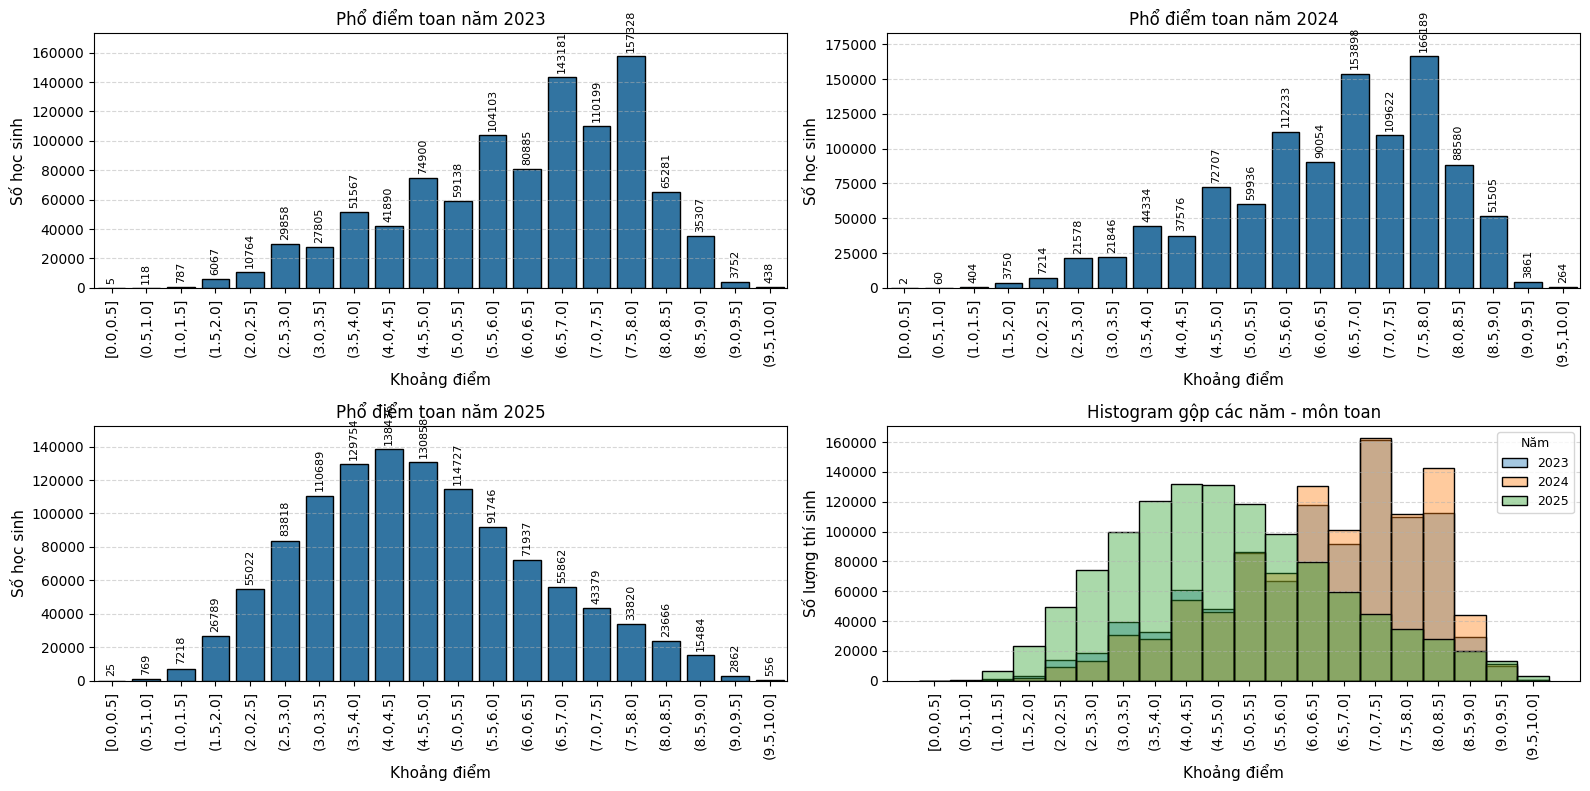

📌 [KDE] Đang xử lý môn: toan (toan)


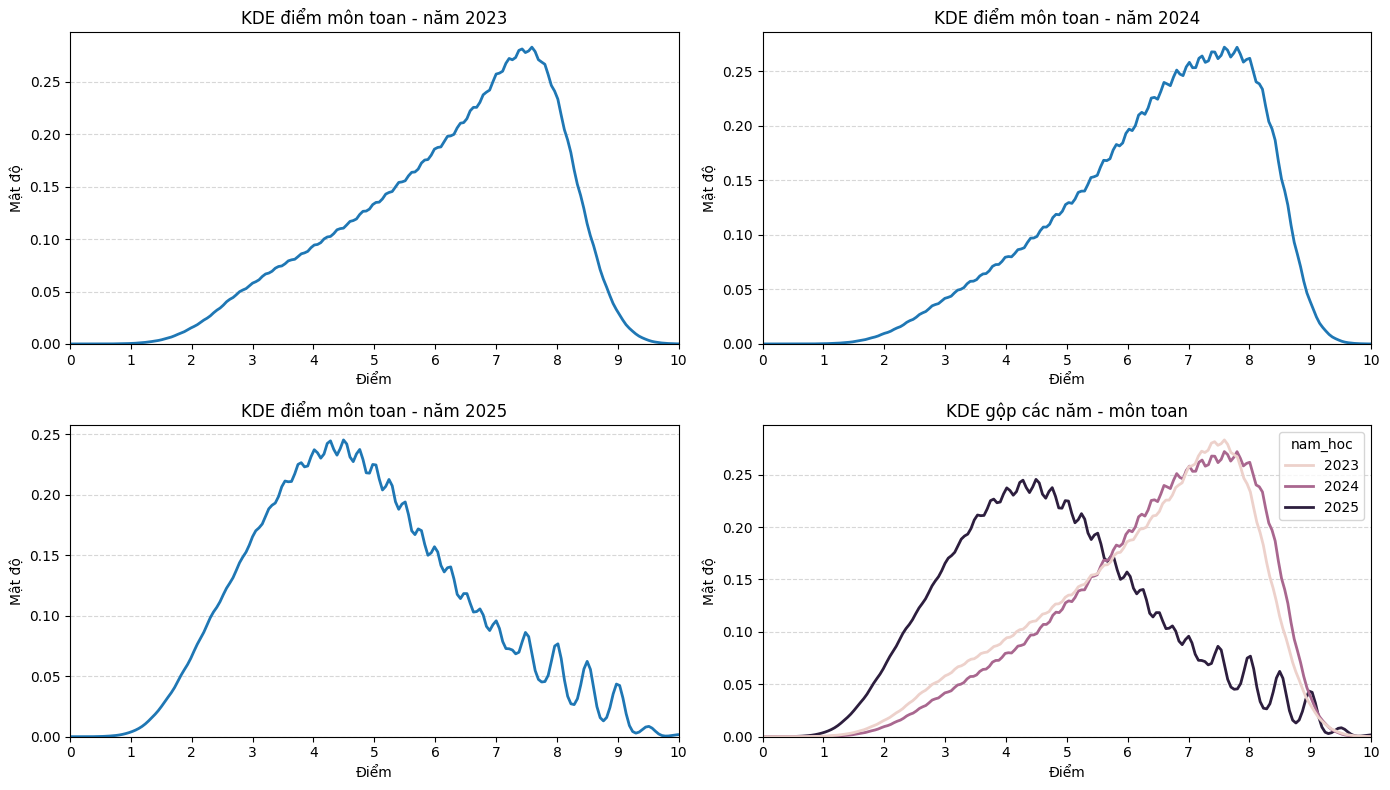

📌 [Boxplot + Stats] Đang xử lý môn: toan (toan)


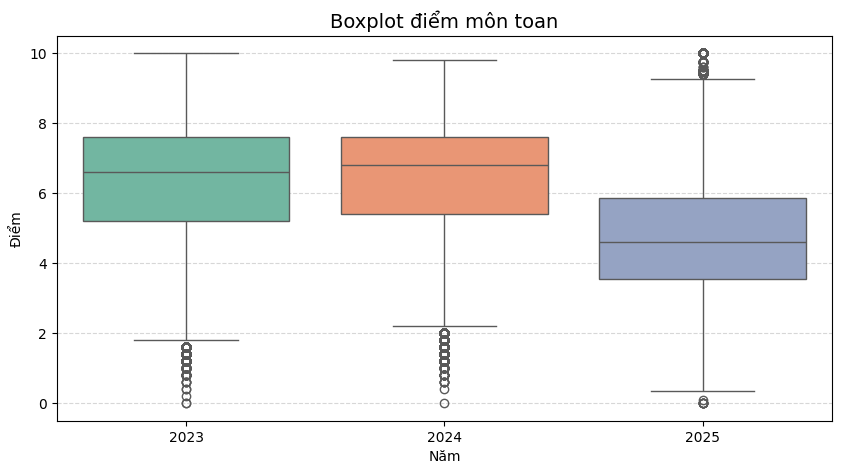


📊 Bảng thống kê mô tả:


,mean,median,std,%>=5,%>=8
nam_hoc,,,,,
2023,6.250557,6.6,1.633336,78.36,15.16
2024,6.447309,6.8,1.556900,82.51,18.97
2025,4.799712,4.6,1.688549,43.94,5.67


------------------------------------------------------------
================ Hoàn thành EDA môn toan ================



In [15]:
# Chạy EDA cho môn đã chọn
visualize_subject_eda_all(ChoiceSubj, subject_map[choice])


## Kiểm định ANOVA & t-test

In [16]:
# 1. Tạo object kiểm định từ distribution của môn đã chọn
anova_ttest = ANOVA_ttest(
    ChoiceSubj_df,
    group_col="nam_hoc",   # nhóm theo năm
    score_col="diem"       # cột điểm dùng để kiểm định
)

# 2. T-test môn học giữa 2 năm
ttest_subj = anova_ttest.t_test_subject_two_years(
    subject=ChoiceSubj,    # ví dụ: "toan"
    year1=2024,
    year2=2025
)

print("\n📌 Kết quả kiểm định t-test giữa 2 năm 2024 và 2025:")
display(ttest_subj)

# 3. ANOVA môn học qua các năm
anova_subj = anova_ttest.anova_subject(subject=ChoiceSubj)

print("\n📌 Kết quả kiểm định ANOVA qua các năm:")
display(anova_subj)



📌 Kết quả kiểm định t-test giữa 2 năm 2024 và 2025:


{'subject': 'toan',
 'year1': 2024,
 'year2': 2025,
 't_stat': 750.0764328602297,
 'p_value': 1e-16,
 'p_value_text': '< 1e-16',
 'one_tail': False,
 'alternative': 'less',
 'cohens_d': 1.014493182985406,
 'effect_strength': 'Mạnh',
 'interpretation': 'Có sự khác biệt.'}


📌 Kết quả kiểm định ANOVA qua các năm:


{'subject': 'toan',
 'anova_f': 335411.88782491116,
 'anova_p': 1e-16,
 'anova_p_text': '< 1e-16',
 'interpretation': 'Có khác biệt giữa các năm.'}

## Nhận xét: 

******

# Theo Khối

In [17]:
# Danh sách 10 khối tuyển sinh phổ biến
block_options = {
    1: "A00",
    2: "A01",
    3: "A02",
    4: "B00",
    5: "C00",
    6: "C01",
    7: "D01",
    8: "D07",
    9: "D66",
    10: "D84",
    11: "Khác"     # Tự nhập
}

print("=== Danh sách khối tuyển sinh ===")
for k, v in block_options.items():
    print(f"{k}: {v}")

raw = input("\nNhập các số khối bạn muốn chọn (vd: 1,3,5 hoặc 1 3 5 11): ")

# Tách theo dấu phẩy hoặc khoảng trắng
tokens = [t for part in raw.replace(',', ' ').split() for t in [part] if t]

selected_blocks = []
has_custom = False

for tok in tokens:
    if not tok.isdigit():
        print(f"⚠ Bỏ qua giá trị không hợp lệ: {tok}")
        continue

    choice = int(tok)

    if choice in block_options and choice != 11:
        block = block_options[choice]
        if block not in selected_blocks:   # tránh trùng
            selected_blocks.append(block)
    elif choice == 11:
        has_custom = True
    else:
        print(f"⚠ Lựa chọn không hợp lệ: {choice}")

# Nếu người dùng chọn "Khác" (11) → cho nhập thêm các khối tuỳ chọn
if has_custom:
    custom_raw = input("Nhập tên các khối tuỳ chọn (vd: A09, C03, X01), cách nhau bởi dấu phẩy: ")
    customs = [c.strip().upper().replace(" ", "") for c in custom_raw.split(',') if c.strip()]
    for cb in customs:
        if cb and cb not in selected_blocks:
            selected_blocks.append(cb)

if not selected_blocks:
    print("❌ Lỗi: Không có khối hợp lệ nào được chọn!")
else:
    print("\nBạn đã chọn các khối:")
    for b in selected_blocks:
        print(" -", b)

# Biến này dùng cho phần sau
blocks_selected = selected_blocks


=== Danh sách khối tuyển sinh ===
1: A00
2: A01
3: A02
4: B00
5: C00
6: C01
7: D01
8: D07
9: D66
10: D84
11: Khác

Bạn đã chọn các khối:
 - A00
 - A02
 - C00


## Tải dữ liệu theo Khối thi được chọn:

In [18]:
# Kiểm tra đã chọn được ít nhất 1 khối chưa
if not blocks_selected:
    raise ValueError("Không có khối hợp lệ nào được chọn.")

# ---- CÁCH 1: Lưu riêng từng khối vào dict ----
#   - Dùng khi muốn phân tích/plot từng khối tách biệt

block_dist_dict = {}
block_analysis_dict = {}

for blk in blocks_selected:
    # Lấy dữ liệu phân phối điểm của từng khối
    block_dist_dict[blk] = clean_data.get_block_data(block=blk, kind="distribution")
    block_analysis_dict[blk] = clean_data.get_block_data(block=blk, kind="analysis")

# Gộp distribution của các khối thành 1 DataFrame
dist_list = []
for blk, df_blk in block_dist_dict.items():
    # đảm bảo có cột 'khoi' nhận đúng tên khối
    df_blk = df_blk.copy()
    if "khoi" not in df_blk.columns:
        df_blk["khoi"] = blk
    dist_list.append(df_blk)

ChoiceBlock_df = pd.concat(dist_list, ignore_index=True)

# Tương tự cho bảng analysis
anal_list = []
for blk, df_blk in block_analysis_dict.items():
    df_blk = df_blk.copy()
    if "khoi" not in df_blk.columns:
        df_blk["khoi"] = blk
    anal_list.append(df_blk)

ChoiceBlock_analyst = pd.concat(anal_list, ignore_index=True)


## Xây dựng hàm trực quan hóa theo Khối thi:

In [19]:
# 🔹Hàm thể hiện xu hướng chọn khối

In [20]:
# Phân tích xu hướng chọn khối thi (dùng ChoiceBlock_df)
def visualize_block_trends(blocks=None):
    """
    Vẽ biểu đồ Stacked Area thể hiện tỷ lệ thí sinh theo các khối thi,
    sử dụng dữ liệu từ ChoiceBlock_df (distribution nhiều khối đã gộp).

    Yêu cầu ChoiceBlock_df có tối thiểu các cột:
        - 'nam_hoc' : năm thi
        - 'khoi'    : tên khối (A00, B00, ...)
        - 'so_hoc_sinh' : số thí sinh tương ứng (từ bảng distribution)
    """
    print("--- Đang tổng hợp dữ liệu các khối thi từ ChoiceBlock_df... ---")

    # Dùng bản copy cho an toàn
    df = ChoiceBlock_df.copy()

    # Nếu truyền danh sách khối cụ thể -> lọc lại
    if blocks is not None:
        df = df[df["khoi"].isin(blocks)]

    if df.empty:
        print("⚠ Không có dữ liệu khối nào sau khi lọc!")
        return

    # Gom số học sinh theo (nam_hoc, khoi)
    # vì ChoiceBlock_df là distribution theo điểm, nên phải sum 'so_hoc_sinh'
    df_counts = (
        df.groupby(["nam_hoc", "khoi"])["so_hoc_sinh"]
          .sum()
          .unstack("khoi")           # đưa 'khoi' thành cột
          .fillna(0)
          .astype(int)
    )

    if df_counts.empty:
        print("⚠ Không có dữ liệu sau groupby!")
        return

    # Sắp xếp index năm cho đúng thứ tự
    # (giả sử nam_hoc là số hoặc chuỗi số)
    try:
        df_counts.index = df_counts.index.astype(int)
    except ValueError:
        # Nếu không ép được sang int thì giữ nguyên
        pass

    df_counts = df_counts.sort_index()

    # Tính % theo hàng (từng năm)
    df_percent = df_counts.div(df_counts.sum(axis=1), axis=0) * 100

    # Nếu sau khi chia mà có NaN (năm nào đó tổng = 0) thì bỏ năm đó
    df_percent = df_percent.dropna(how="all")
    df_counts = df_counts.loc[df_percent.index]

    if df_percent.empty:
        print("⚠ Không có năm nào có dữ liệu hợp lệ để vẽ!")
        return

    # --- VẼ BIỂU ĐỒ ---
    plt.figure(figsize=(12, 7))

    # Chuẩn bị trục x: danh sách năm
    years = list(df_percent.index)

    # Stackplot: x = năm, y = ma trận % (shape: n_khoi x n_nam)
    plt.stackplot(
        years,
        df_percent.T.values,          # mỗi hàng là 1 khối
        labels=df_percent.columns,
        alpha=0.85
    )

    plt.title("Xu hướng lựa chọn khối thi (Tỷ lệ %)", fontsize=16)
    plt.xlabel("Năm học", fontsize=12)
    plt.ylabel("Tỷ lệ (%)", fontsize=12)
    plt.legend(loc="upper left", title="Khối thi", bbox_to_anchor=(1, 1))

    # Trục hoành: hiển thị đúng các năm có trong dữ liệu
    xtick_labels = [str(y) for y in years]
    plt.xticks(years, xtick_labels)

    # Giới hạn trục x và y cho gọn + bỏ khoảng trắng 2 bên
    plt.xlim(min(years), max(years))
    plt.ylim(0, 100)
    plt.margins(0, 0)

    # Thêm grid chia miền (đường ngang + dọc)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    for x in years:
        plt.axvline(x=x, linestyle=":", alpha=0.25)  # đường chia theo từng năm

    # Ghi giá trị % lên từng “lớp” stack (nếu đủ lớn)
    for i, year in enumerate(years):
        cum = 0.0  # tích luỹ phần trăm trước đó (để biết vị trí giữa dải)
        for block in df_percent.columns:
            val = df_percent.loc[year, block]
            # Bỏ qua % quá nhỏ cho đỡ rối
            if val < 3:
                cum += val
                continue

            y_pos = cum + val / 2.0   # giữa dải của khối đó
            plt.text(
                year,
                y_pos,
                f"{val:.1f}%",         # ví dụ: 23.4%
                ha="center",
                va="center",
                fontsize=8
            )
            cum += val

    plt.tight_layout()
    plt.show()


    print("\n📊 Bảng số lượng thí sinh chi tiết theo năm/khối:")
    display(df_counts)

--- Đang tổng hợp dữ liệu các khối thi từ ChoiceBlock_df... ---


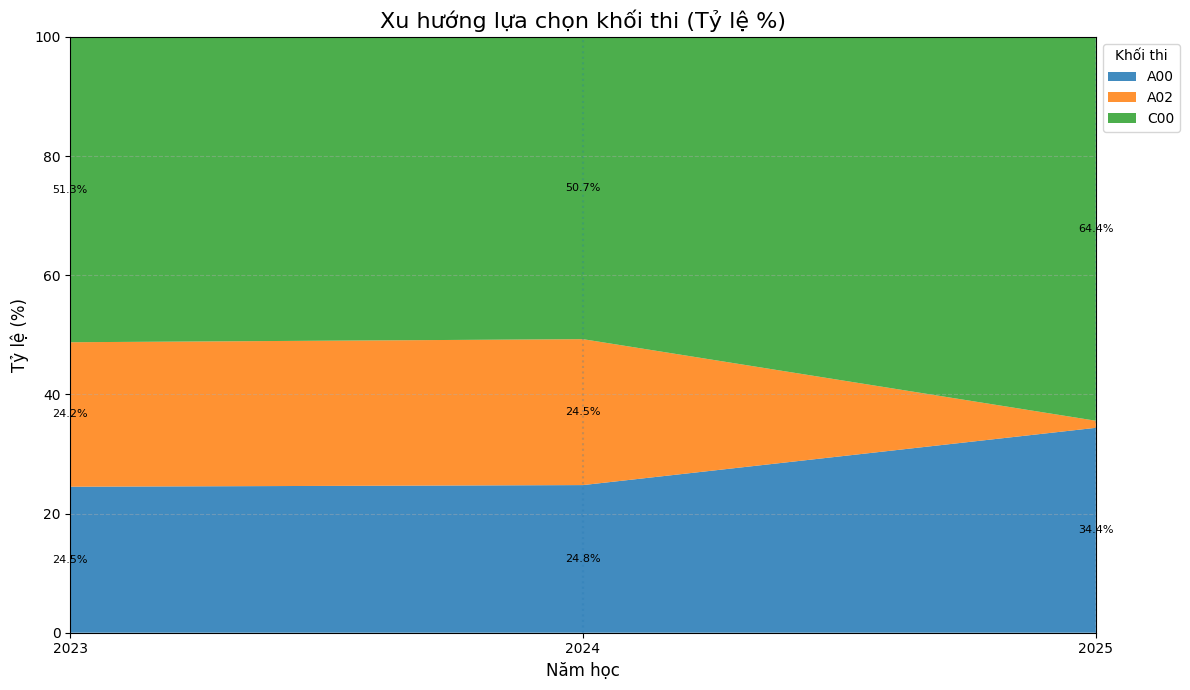


📊 Bảng số lượng thí sinh chi tiết theo năm/khối:


khoi,A00,A02,C00
nam_hoc,,,
2023,325902,322538,681723
2024,343800,339801,704008
2025,165467,5708,310012


In [21]:
visualize_block_trends(blocks=blocks_selected)


### 🔹 Khung 1 – Histogram theo từng năm

📌 [Histogram theo khoảng] Khối: A00


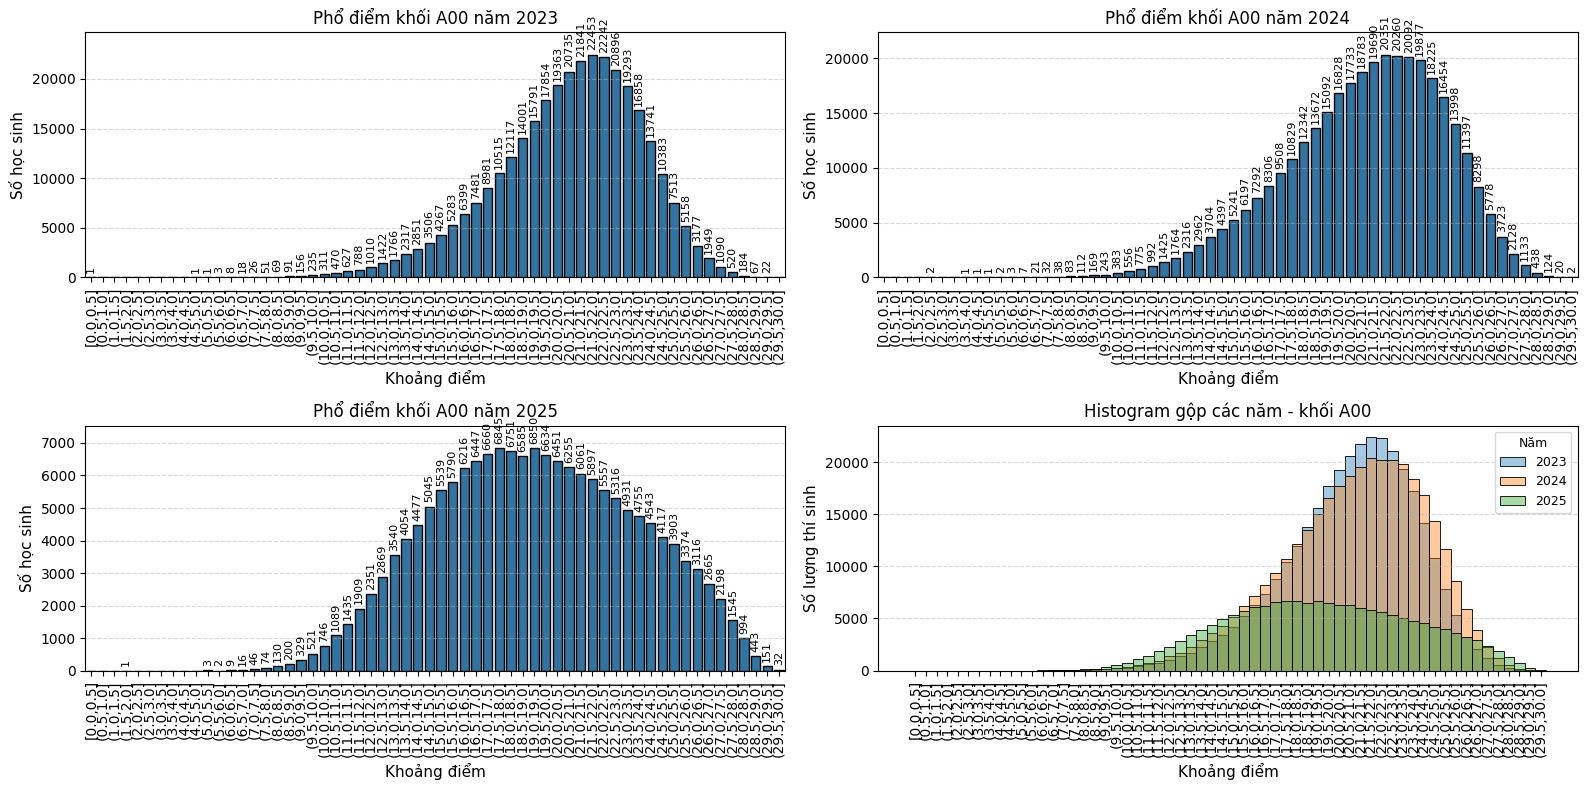

📌 [Histogram theo khoảng] Khối: A02


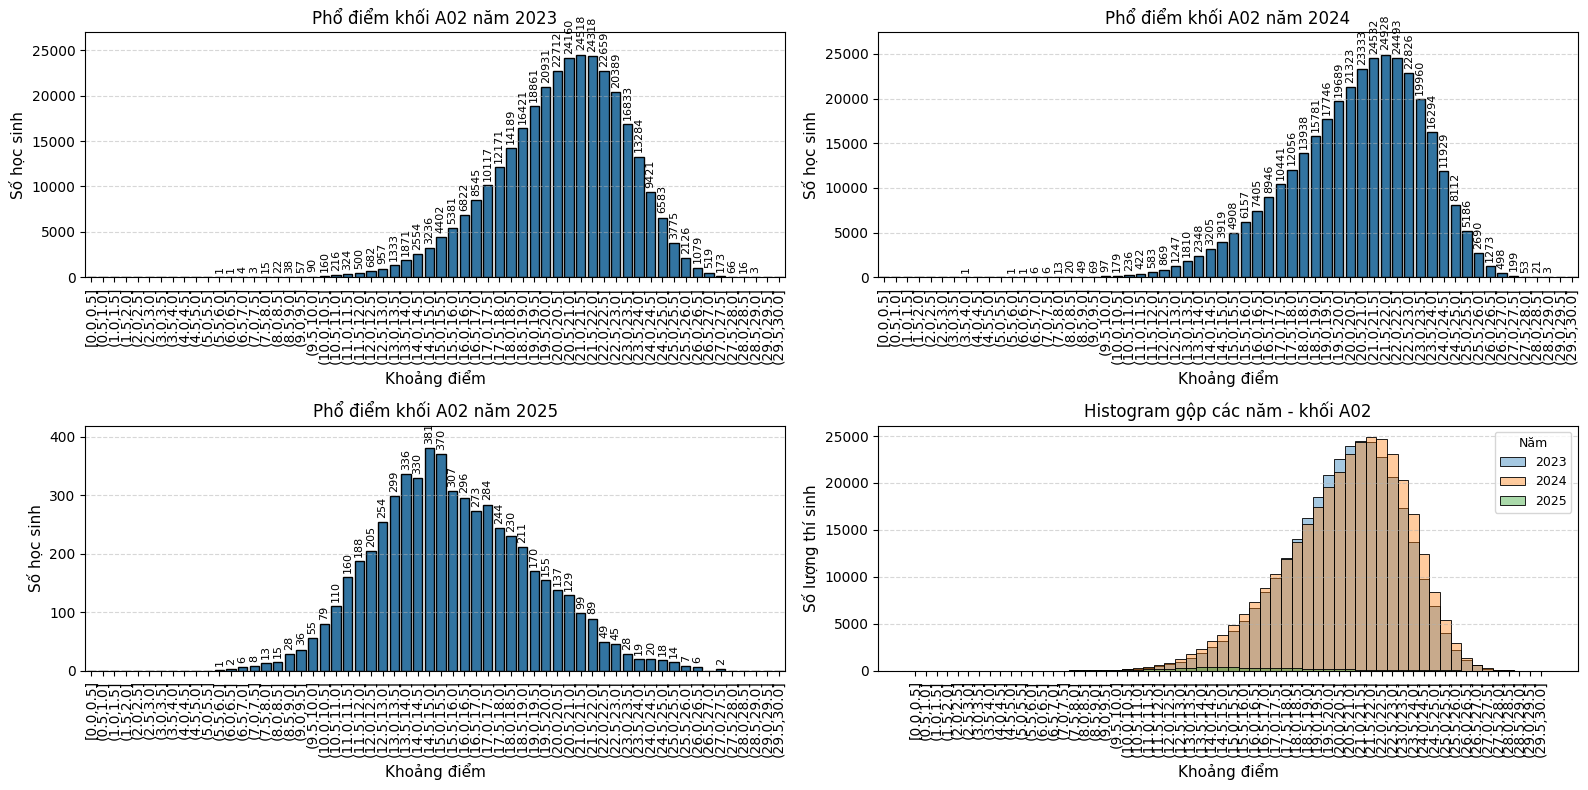

📌 [Histogram theo khoảng] Khối: C00


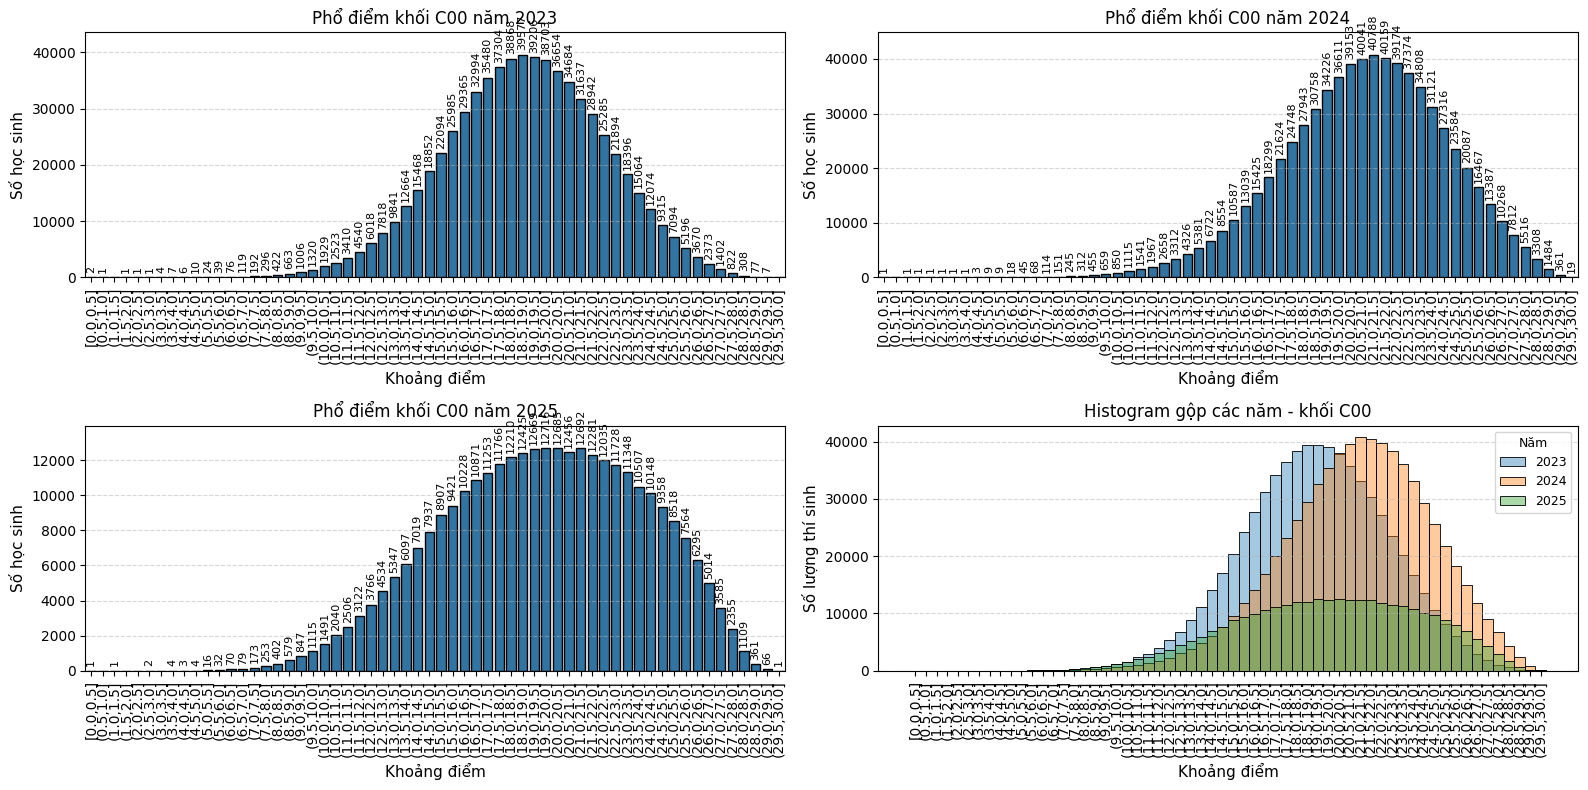

In [22]:
# Kế hoạch EDA cụ thể cho bộ dữ liệu thi THPTQG 2023–2025
# Theo khối thi (Block_Data):
# – Sử dụng tổng điểm các khối cơ bản (A00, B00, D01, C00, . . . ):
# * Vẽ histogram/KDE theo năm để đánh giá độ khó của từng khối.
# * Vẽ boxplot tổng điểm từng khối qua 3 năm

# Vẽ histogram
def visualize_block_hist(block_code: str):
    """
    Vẽ histogram theo KHOẢNG ĐIỂM cho một khối thi, gồm 2 phần:

    1) Histogram từng năm (mỗi năm 1 ô riêng) theo khoảng:
       [0,0.5], (0.5,1], (1,1.5], ..., (29.5,30]
       -> Thể hiện bằng barplot (sns.barplot) trên trục x là các khoảng điểm.
    2) Một histogram GỘP CÁC NĂM trong cùng một khung (ô thứ 4),
       dùng seaborn.histplot, overlay các năm, vẫn chia khoảng như trên.
    """
    print(f"📌 [Histogram theo khoảng] Khối: {block_code}")

    # 1. Lấy dữ liệu phân phối (distribution) của khối
    df_agg = clean_data.get_block_data(block=block_code, kind="distribution")

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho khối {block_code}")
        return

    # 2. Định nghĩa chung: edges & labels cho KHOẢNG ĐIỂM
    #    edges: [-1e-6, 0.5, 1, 1.5, ..., 30]
    edges = np.concatenate((
        np.array([-1e-6, 0.5]),   # ~ [0,0.5]
        np.arange(1, 30.5, 0.5)   # 1, 1.5, 2, ..., 30
    ))

    # edges để HIỂN THỊ label (không để -1e-6 trên trục)
    display_edges = edges.copy()
    display_edges[0] = 0.0

    # tạo nhãn cho từng khoảng: [0,0.5], (0.5,1], ...
    labels = []
    labels.append(f"[{display_edges[0]},{display_edges[1]}]")   # bin đầu

    for i in range(1, len(display_edges) - 1):
        labels.append(f"({display_edges[i]},{display_edges[i+1]}]")

    # tâm mỗi bin để dùng cho tick / hist gộp
    centers = (edges[:-1] + edges[1:]) / 2

    # 3. Tạo figure 2x2
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    axes = axes.ravel()  # flatten: axes[0], axes[1], axes[2], axes[3]

    # 4. Hàm con: vẽ barplot theo khoảng cho 1 năm lên 1 axis
    def _plot_single_year(points: np.ndarray, year: int, ax):
        """
        Vẽ barplot theo khoảng cho 1 năm, dùng sns.barplot,
        trục x là các khoảng điểm, trục y là số học sinh.
        """
        # Gán mỗi điểm vào 1 khoảng (bin)
        bins_cat = pd.cut(
            points,
            bins=edges,
            labels=labels,
            include_lowest=True,
            right=True
        )

        # Đếm số lượng theo từng khoảng
        bin_counts = (
            pd.DataFrame({"bin": bins_cat})
            .groupby("bin", observed=False)
            .size()
            .reindex(labels, fill_value=0)   # đảm bảo đủ mọi khoảng, kể cả count=0
            .reset_index(name="count")
        )

        sns.barplot(
            data=bin_counts,
            x="bin",
            y="count",
            order=labels,
            color="C0",
            edgecolor="black",
            ax=ax,
        )

        ax.set_title(f"Phổ điểm khối {block_code} năm {year}", fontsize=12)
        ax.set_xlabel("Khoảng điểm", fontsize=11)
        ax.set_ylabel("Số học sinh", fontsize=11)
        ax.tick_params(axis="x", rotation=90)  # chỉ xoay label, không set_ticklabels
        ax.grid(axis="y", linestyle="--", alpha=0.5)

        # ---- Đặt y-limit & số trên đầu cột ----
        max_count = bin_counts["count"].max()
        ax.set_ylim(0, max_count * 1.10 if max_count > 0 else 1)

        for p in ax.patches:
            height = p.get_height()
            if height == 0:
                continue
            ax.annotate(
                text=str(int(height)),
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),                  # lệch lên 3 điểm ảnh
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,
                rotation=90,
            )
    # 5. Vẽ barplot THEO TỪNG NĂM (tối đa 3 ô đầu)
    years = sorted(df_agg["nam_hoc"].unique())
    all_raw = []   # để gom lại cho phần hist gộp   
    for idx, year in enumerate(years[:3]):
        df_year = df_agg[df_agg["nam_hoc"] == year]

        # tái tạo điểm thô của năm đó
        points_year = np.repeat(
            df_year["tong_diem"].values,
            df_year["so_hoc_sinh"].values.astype(int)
        )
        all_raw.append(pd.DataFrame({"nam_hoc": year, "diem": points_year}))

        # vẽ barplot theo khoảng cho riêng năm này lên axes[idx]
        _plot_single_year(points_year, year, axes[idx])
    # Nếu số năm < 3 → tắt những ô dư (0,1,2 chỉ dùng theo số year)
    for idx in range(len(years), 3):
        axes[idx].axis("off")
    # 6. VẼ HISTOGRAM GỘP CÁC NĂM TRONG Ô THỨ 4
    full_df = pd.concat(all_raw, ignore_index=True)
    ax4 = axes[3]
    for year in years:
        sns.histplot(
            data=full_df[full_df["nam_hoc"] == year],
            x="diem",
            bins=edges,          # dùng khoảng chia custom
            kde=False,
            stat="count",
            element="bars",
            alpha=0.4,
            label=str(year),
            ax=ax4,
        )
    ax4.set_title(
        f"Histogram gộp các năm - khối {block_code}",
        fontsize=12
    )
    ax4.set_xlabel("Khoảng điểm", fontsize=11)
    ax4.set_ylabel("Số lượng thí sinh", fontsize=11)
    ax4.grid(axis="y", linestyle="--", alpha=0.5)
    ax4.legend(title="Năm", fontsize=9, title_fontsize=9)
    # Gắn nhãn khoảng điểm cho trục x (dùng centers + labels)
    ax4.set_xticks(centers)
    ax4.set_xticklabels(labels, rotation=90)
    plt.tight_layout()
    plt.show()
    
    
# Chạy histogram cho từng khối đã chọn
for blk in blocks_selected:
    visualize_block_hist(blk)
    

### 🔹 Khung 2 – KDE chồng các năm

📌 [KDE] Đang xử lý khối: A00


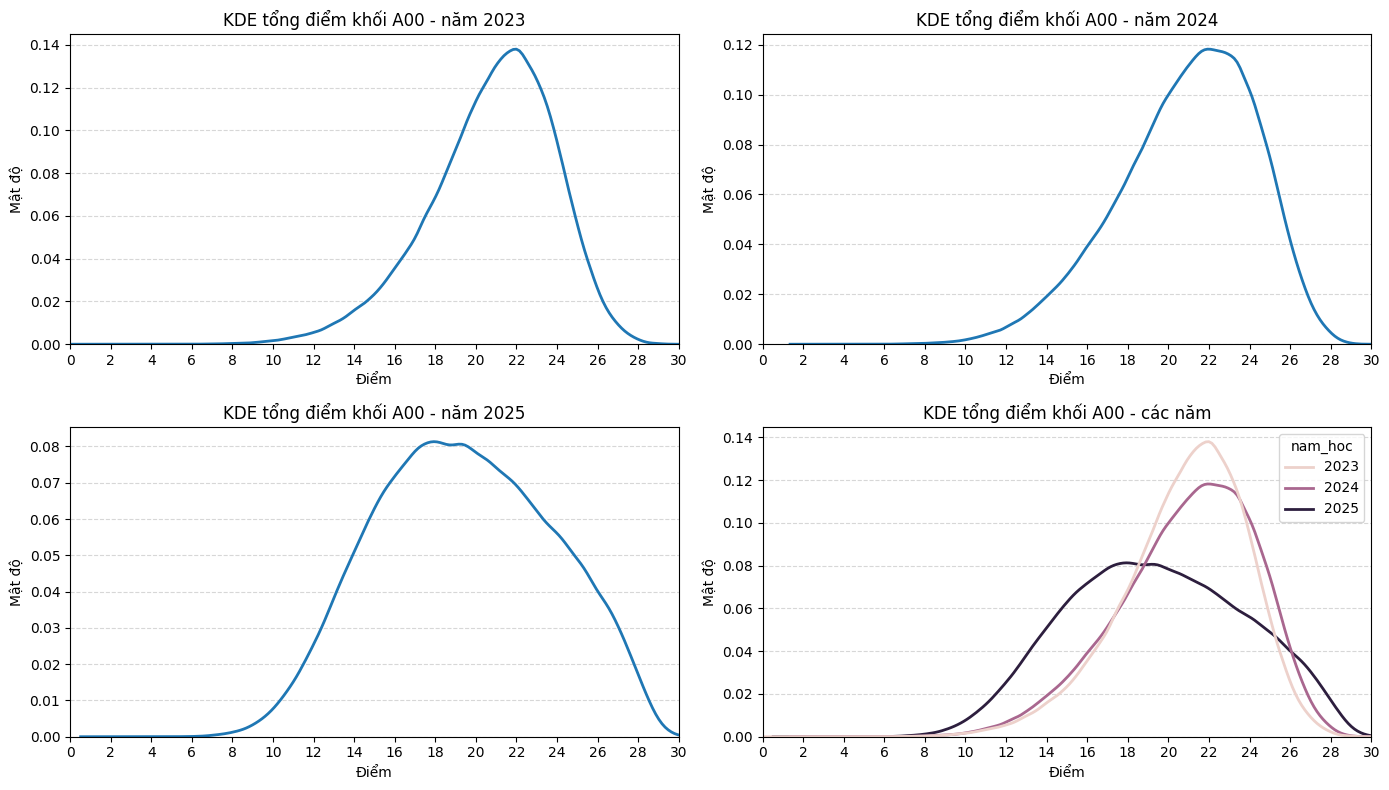

📌 [KDE] Đang xử lý khối: A02


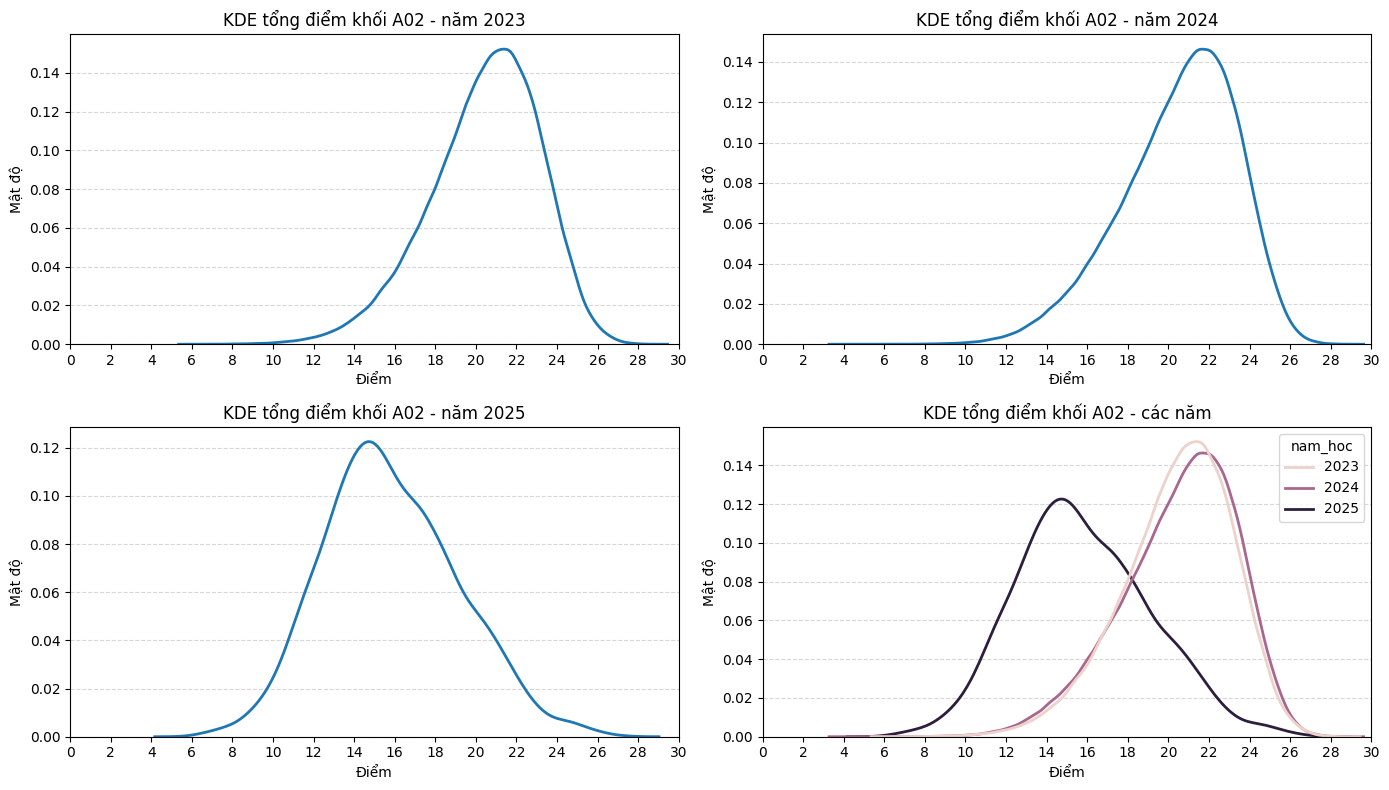

📌 [KDE] Đang xử lý khối: C00


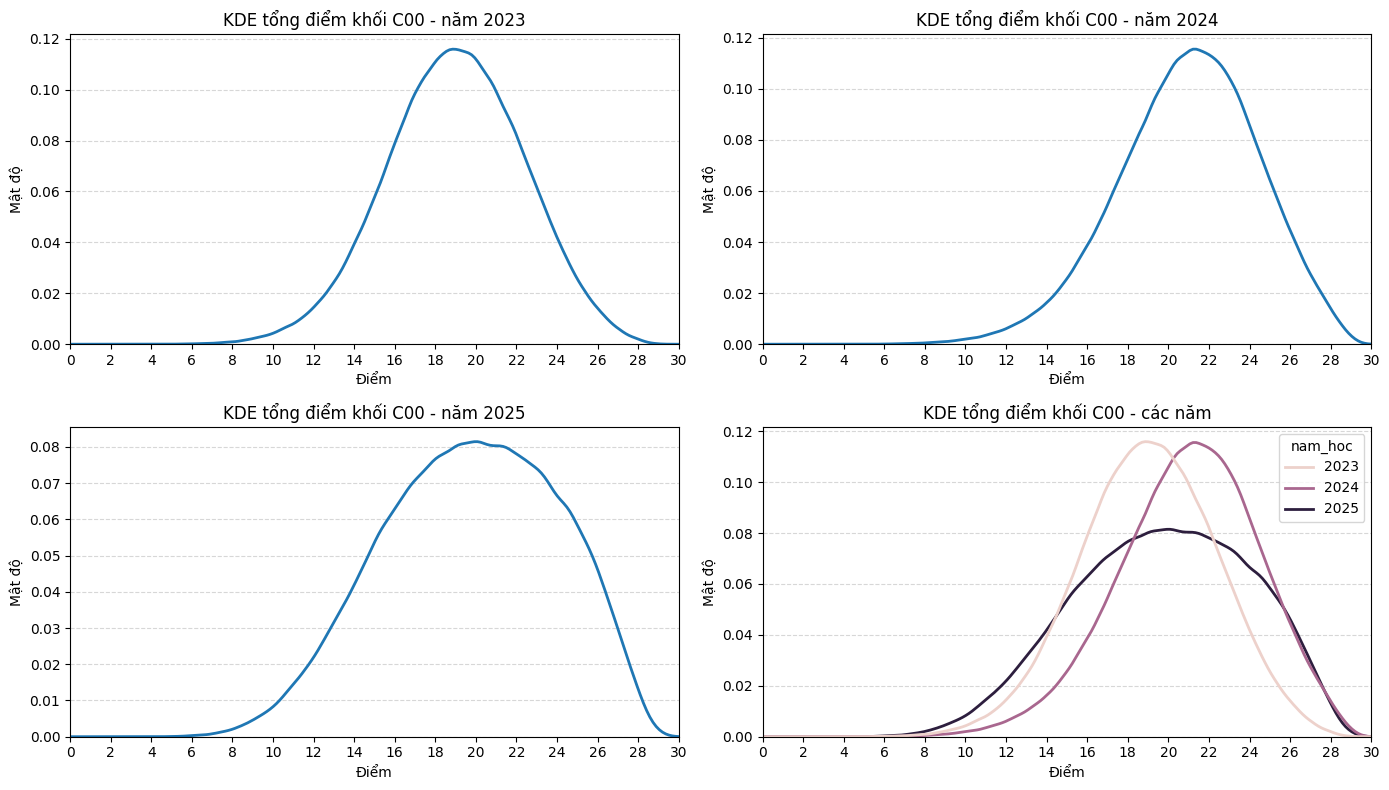

In [23]:
# Kế hoạch EDA cụ thể cho bộ dữ liệu thi THPTQG 2023–2025
# Theo khối thi (Block_Data):
# – Sử dụng tổng điểm các khối cơ bản (A00, B00, D01, C00, . . . ):
# * Vẽ KDE theo năm để đánh giá độ khó của từng khối.


# Vẽ KDE
def visualize_block_kde(block_code: str):
    """
    Vẽ đường KDE (mật độ) tổng điểm cho một khối thi cụ thể.

    - Dùng dữ liệu phân phối (kind="distribution").
    - Chia figure 2x2:
        + 3 ô đầu: KDE từng năm (mỗi năm 1 subplot).
        + Ô thứ 4: KDE chồng các năm để so sánh phân phối điểm.
    """
    print(f"📌 [KDE] Đang xử lý khối: {block_code}")

    # 1. Lấy dữ liệu tần suất từ Analysis (bản distribution)
    df_agg = clean_data.get_block_data(block=block_code, kind="distribution")

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho khối {block_code}")
        return

    # 2. Tái tạo dữ liệu thô từ tần suất
    raw = []
    years = sorted(df_agg["nam_hoc"].unique())

    for year in years:
        df_y = df_agg[df_agg["nam_hoc"] == year]
        scores = np.repeat(
            df_y["tong_diem"].values,
            df_y["so_hoc_sinh"].values.astype(int)
        )
        raw.append(pd.DataFrame({"nam_hoc": year, "diem": scores}))

    full_df = pd.concat(raw, ignore_index=True)

    # 3. Tạo figure 2x2: 3 ô cho từng năm, 1 ô gộp 3 năm
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    axes = axes.ravel()  # flatten thành 1D: axes[0], axes[1], axes[2], axes[3]

    # -----------------------------
    # 3.1 KDE TỪNG NĂM (tối đa 3 năm)
    # -----------------------------
    for idx, year in enumerate(years[:3]):
        ax = axes[idx]
        data_year = full_df[full_df["nam_hoc"] == year]["diem"]

        sns.kdeplot(
            x=data_year,
            fill=False,
            linewidth=2,
            ax=ax,
        )

        ax.set_title(f"KDE tổng điểm khối {block_code} - năm {year}", fontsize=12)
        ax.set_xlabel("Điểm")
        ax.set_ylabel("Mật độ")
        ax.set_xlim(0, 30)
        ax.set_xticks(np.arange(0, 30.5, 2))
        ax.grid(axis="y", linestyle="--", alpha=0.5)
    # Nếu số năm < 3, tắt những ô dư (trừ ô thứ 4 để gộp)
    for idx in range(len(years), 3):
        axes[idx].axis("off")
    # -----------------------------
    # 3.2 KDE GỘP CÁC NĂM (subplot thứ 4)
    ax4 = axes[3]

    sns.kdeplot(
        data=full_df,
        x="diem",
        hue="nam_hoc",
        common_norm=False,
        fill=False,
        linewidth=2,
        ax=ax4,
    )
    ax4.set_title(f"KDE tổng điểm khối {block_code} - các năm", fontsize=12)
    ax4.set_xlabel("Điểm")
    ax4.set_ylabel("Mật độ")
    ax4.set_xlim(0, 30)
    ax4.set_xticks(np.arange(0, 30.5, 2))
    ax4.grid(axis="y", linestyle="--", alpha=0.5)
    # Legend: chỉ tạo nếu thật sự có handles/labels → tránh UserWarning
    handles, labels = ax4.get_legend_handles_labels()
    if handles:
        ax4.legend(
            handles=handles,
            labels=labels,
            title="Năm",
            fontsize=9,
            title_fontsize=9
        )
    plt.tight_layout()
    plt.show()
    
# Chạy KDE cho từng khối đã chọn
for blk in blocks_selected:
    visualize_block_kde(blk)

### 🔹 Khung 3 – Boxplot + Bảng thống kê mô tả

📌 [Boxplot + Stats] Đang xử lý khối: A00


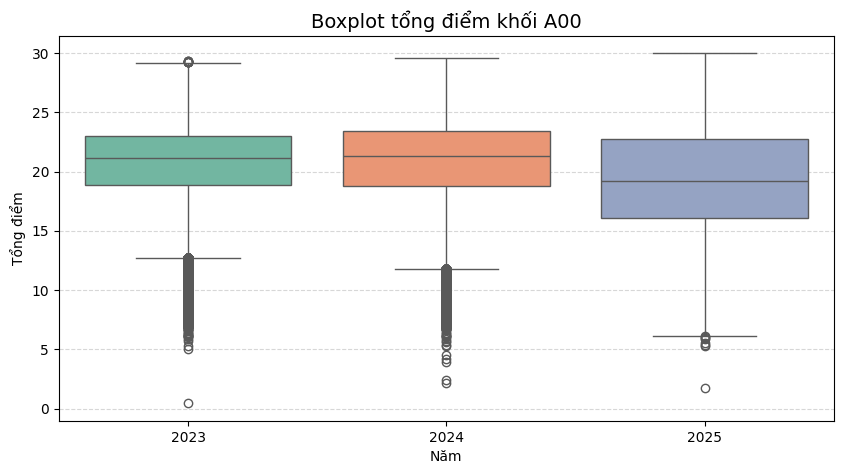


📊 Bảng thống kê mô tả:


,mean,median,std,pct_ge15,pct_ge24
nam_hoc,,,,,
2023,20.774499,21.15,3.094093,95.29,13.94
2024,20.904633,21.30,3.380354,94.33,19.01
2025,19.384368,19.25,4.337350,82.98,17.58


------------------------------------------------------------
📌 [Boxplot + Stats] Đang xử lý khối: A02


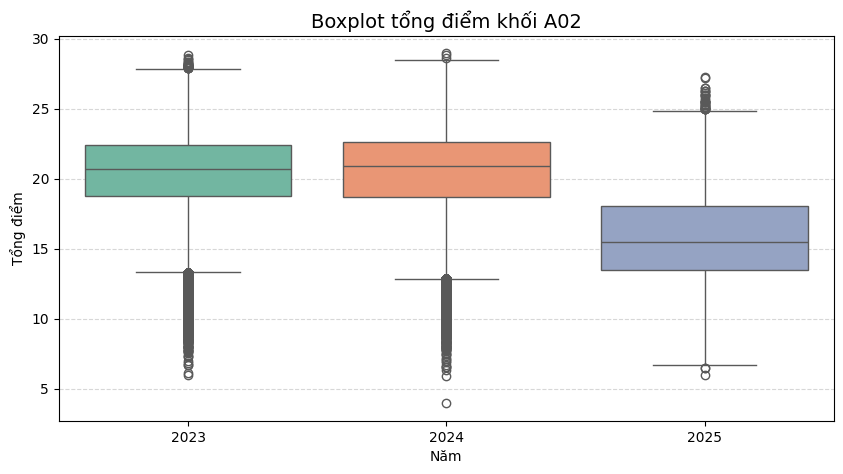


📊 Bảng thống kê mô tả:


,mean,median,std,pct_ge15,pct_ge24
nam_hoc,,,,,
2023,20.426486,20.7,2.725684,96.36,7.72
2024,20.510198,20.9,2.861235,95.70,9.22
2025,15.815566,15.5,3.340573,56.66,1.24


------------------------------------------------------------
📌 [Boxplot + Stats] Đang xử lý khối: C00


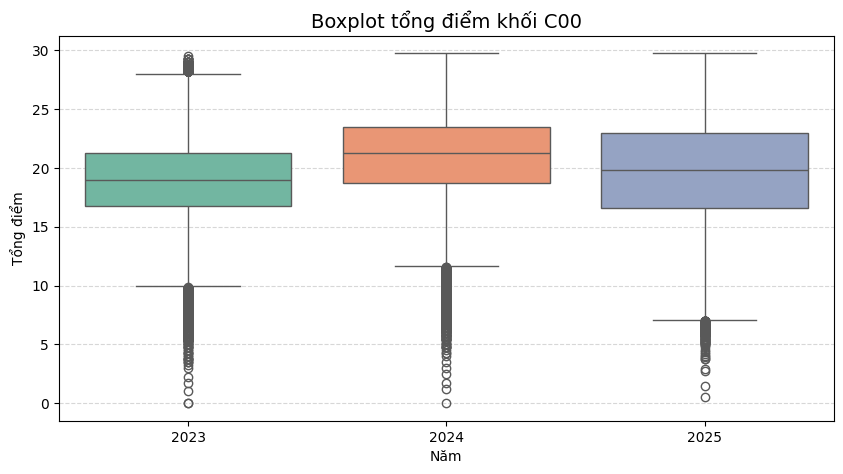


📊 Bảng thống kê mô tả:


,mean,median,std,pct_ge15,pct_ge24
nam_hoc,,,,,
2023,18.974926,19.00,3.378895,88.65,7.25
2024,20.952817,21.25,3.465673,95.17,20.55
2025,19.712084,19.85,4.291575,85.09,18.92


------------------------------------------------------------


In [34]:
# # Kế hoạch EDA cụ thể cho bộ dữ liệu thi THPTQG 2023–2025
# Theo khối thi (Block_Data):
# – Sử dụng tổng điểm các khối cơ bản (A00, B00, D01, C00, . . . ):
# * Vẽ boxplot tổng điểm từng khối qua 3 năm + bảng thống kê mean/median/std/%>=15/%>=24.


def visualize_block_boxplot_and_stats(block_code: str):
    """
    Vẽ Boxplot so sánh phân phối tổng điểm theo năm
    và in ra bảng thống kê mean/median/std/%>=15/%>=24 cho khối thi.

    - Dùng distribution để vẽ & tính %>=15, %>=24.
    - Dùng analysis để lấy các thống kê mean/median/std (min/max nếu cần).
    """
    print(f"📌 [Boxplot + Stats] Đang xử lý khối: {block_code}")

    # 1. Lấy dữ liệu tần suất từ Analysis (bản distribution)
    df_agg = clean_data.get_block_data(block=block_code, kind="distribution")

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho khối {block_code}")
        return

    # 2. Tái tạo dữ liệu thô từ tần suất
    raw = []
    for year in sorted(df_agg["nam_hoc"].unique()):
        df_y = df_agg[df_agg["nam_hoc"] == year]
        scores = np.repeat(
            df_y["tong_diem"].values,
            df_y["so_hoc_sinh"].values.astype(int)
        )
        raw.append(pd.DataFrame({"nam_hoc": year, "diem": scores}))

    full_df = pd.concat(raw, ignore_index=True)

    # 3. Lấy dữ liệu phân tích (analysis) – đã có sẵn mean/median/mode/std/min/max
    stats_raw = clean_data.get_block_data(block=block_code, kind="analysis")

    # stats_raw hiện có dạng:
    # nam_hoc | mean | median | mode | std | min | max
    # → đưa nam_hoc lên làm index cho tiện tra cứu
    stats_df = stats_raw.set_index("nam_hoc").copy()

    # 4. Tính thêm tỷ lệ >=15 và >=24 dựa trên bảng distribution df_agg
    for year in stats_df.index:
        df_y = df_agg[df_agg["nam_hoc"] == year]
        total = df_y["so_hoc_sinh"].sum()
        ge15 = df_y[df_y["tong_diem"] >= 15]["so_hoc_sinh"].sum()
        ge24 = df_y[df_y["tong_diem"] >= 24]["so_hoc_sinh"].sum()
        
        stats_df.loc[year, "pct_ge15"] = ge15 / total * 100 if total > 0 else 0
        stats_df.loc[year, "pct_ge24"] = ge24 / total * 100 if total > 0 else 0
        stats_df.loc[year, "pct_ge15"] = round(stats_df.loc[year, "pct_ge15"], 2)
        stats_df.loc[year, "pct_ge24"] = round(stats_df.loc[year, "pct_ge24"], 2)
    # ----- BOXPLOT -----
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=full_df,
        x="nam_hoc",
        y="diem",
        hue="nam_hoc",        # thêm hue → không bị warning
        dodge=False,          # tránh vẽ 2 box trùng
        palette="Set2",
        vert = True,
    )
    plt.title(f"Boxplot tổng điểm khối {block_code}", fontsize=14)
    plt.xlabel("Năm")
    plt.ylabel("Tổng điểm")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    # Bỏ duplicate legend
    plt.legend().remove()
    plt.show()
    # ----- BẢNG THỐNG KÊ -----
    print("\n📊 Bảng thống kê mô tả:")
    display(stats_df[["mean", "median", "std", "pct_ge15", "pct_ge24"]])
    print("-" * 60)
# Chạy Boxplot + Stats cho từng khối đã chọn
for blk in blocks_selected:
    visualize_block_boxplot_and_stats(blk)

### 🔹EDA Subject - All

================ EDA khối A00 ================
📌 [Histogram theo khoảng] Khối: A00


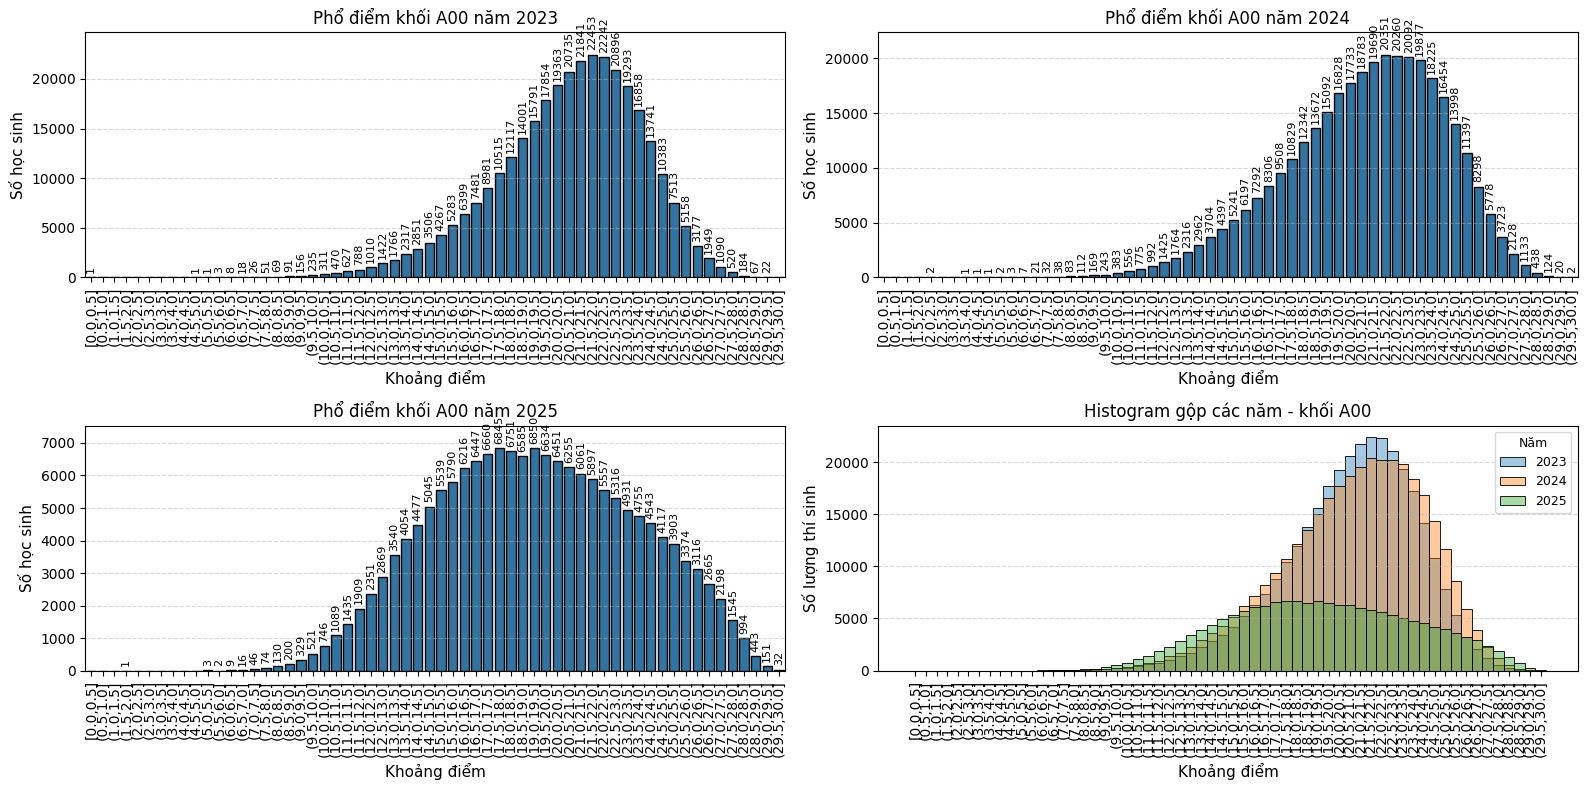

📌 [KDE] Đang xử lý khối: A00


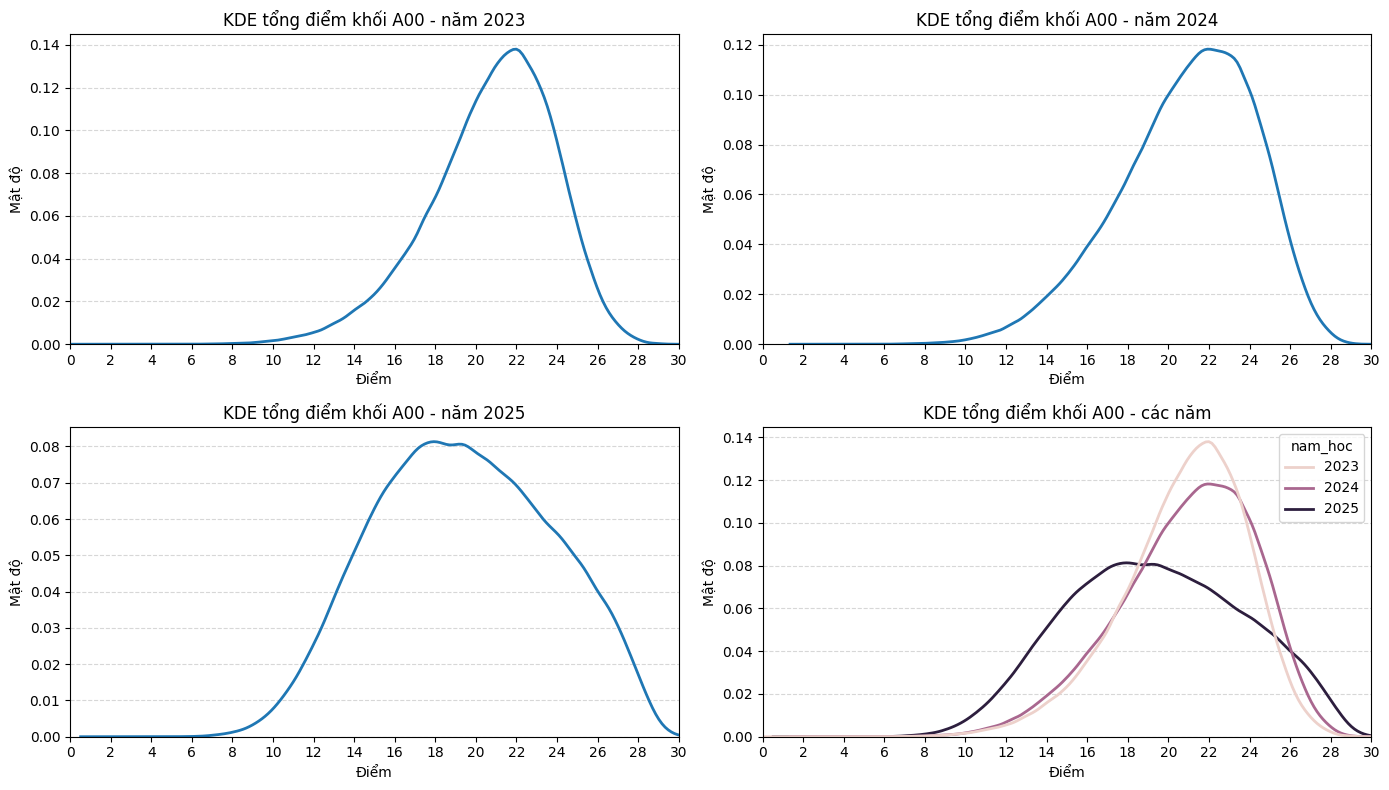

📌 [Boxplot + Stats] Đang xử lý khối: A00


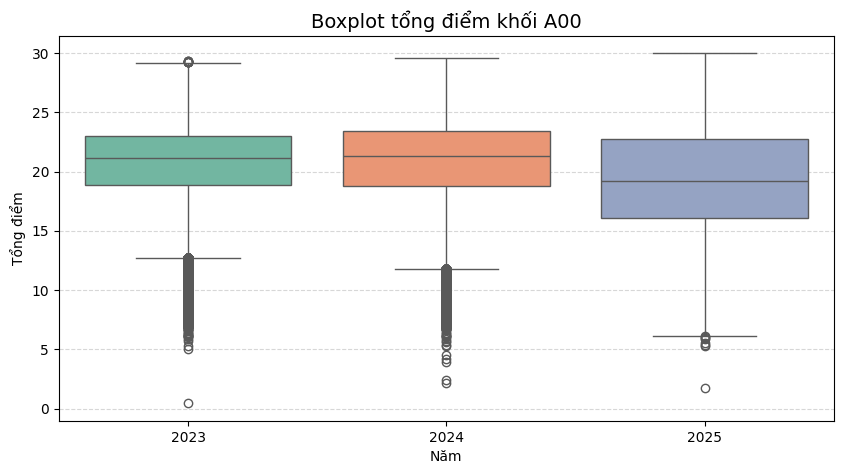


📊 Bảng thống kê mô tả:


,mean,median,std,pct_ge15,pct_ge24
nam_hoc,,,,,
2023,20.774499,21.15,3.094093,95.29,13.94
2024,20.904633,21.30,3.380354,94.33,19.01
2025,19.384368,19.25,4.337350,82.98,17.58


------------------------------------------------------------
================ Hoàn thành EDA khối A00 ================

================ EDA khối A02 ================
📌 [Histogram theo khoảng] Khối: A02


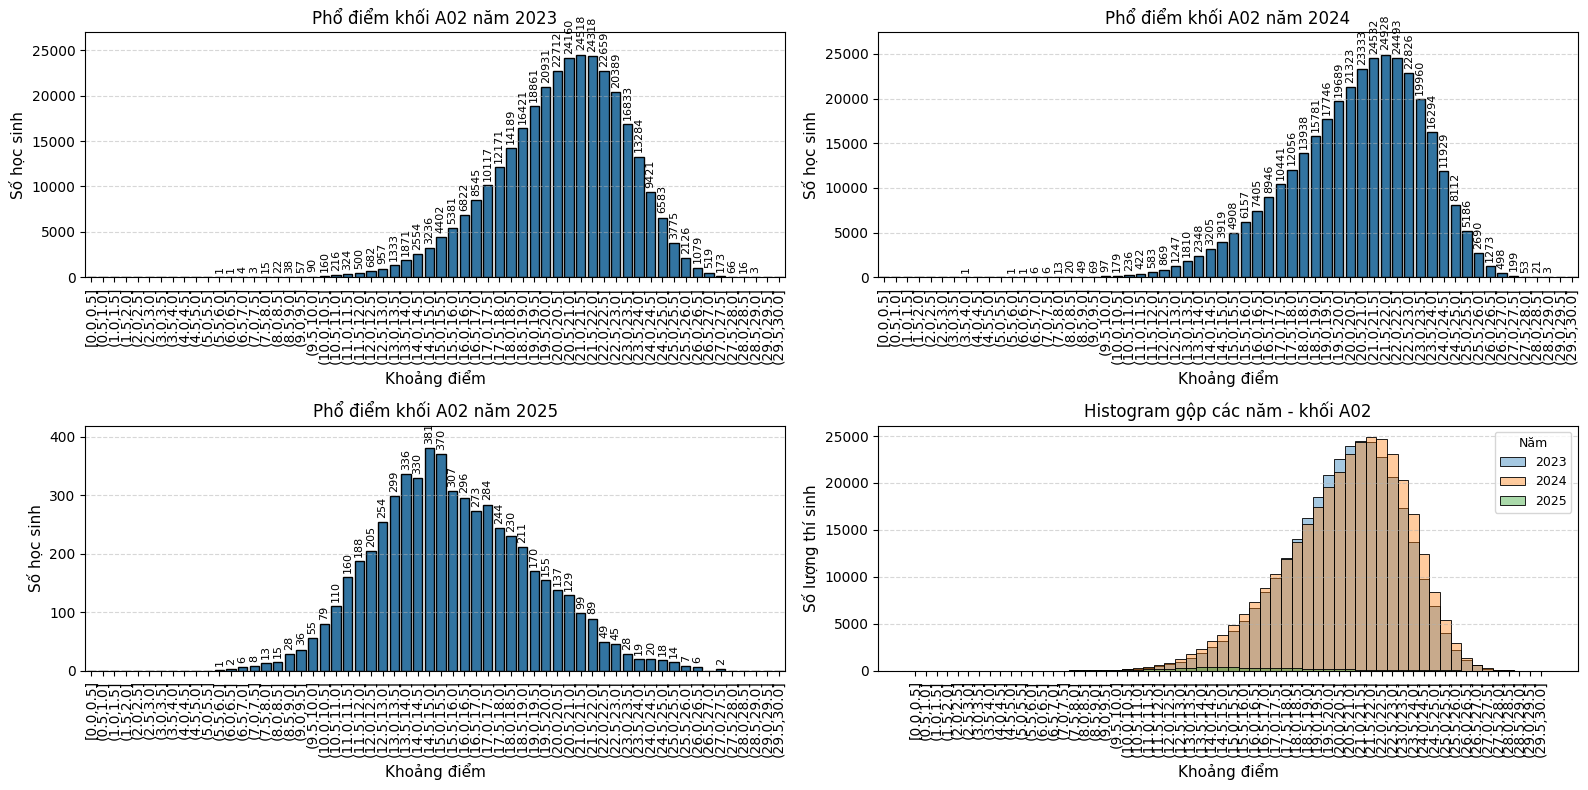

📌 [KDE] Đang xử lý khối: A02


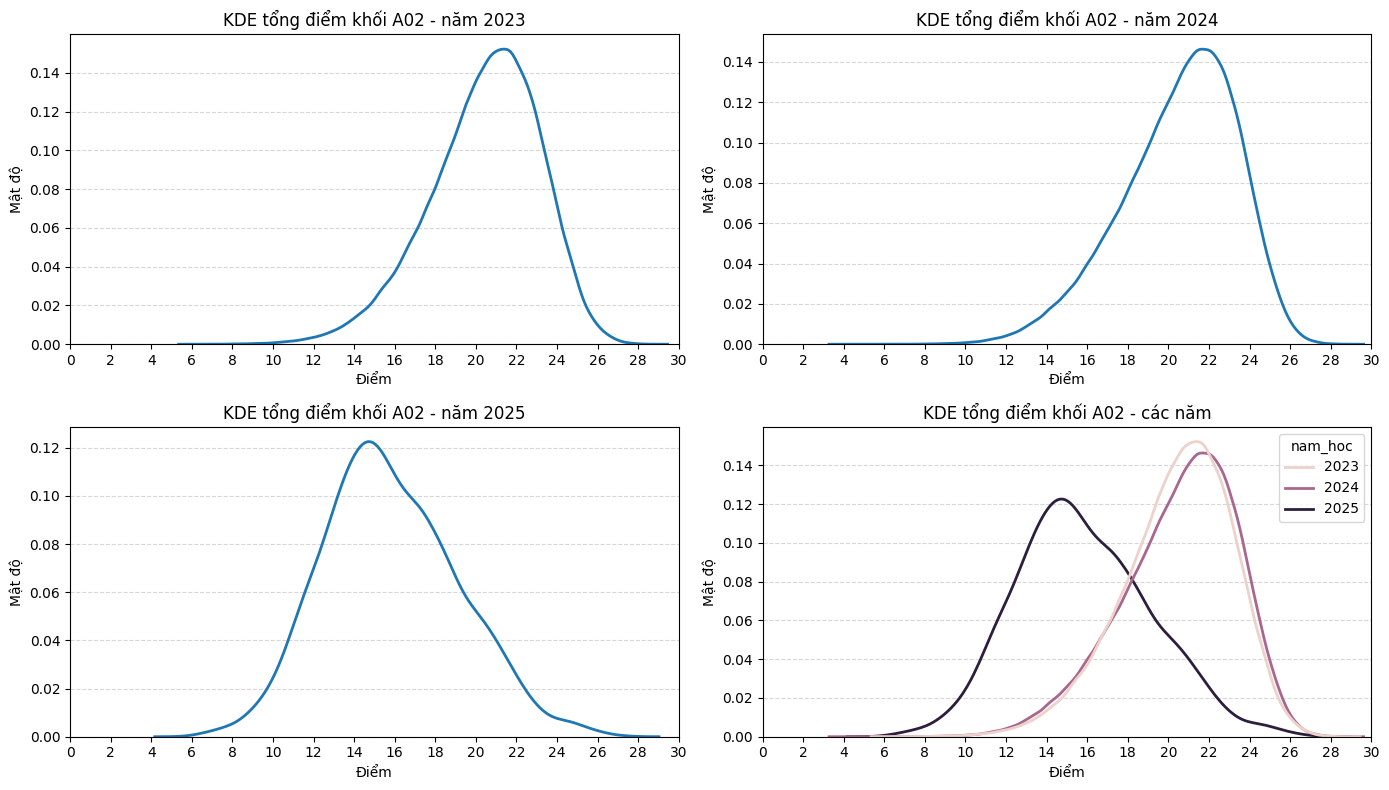

📌 [Boxplot + Stats] Đang xử lý khối: A02


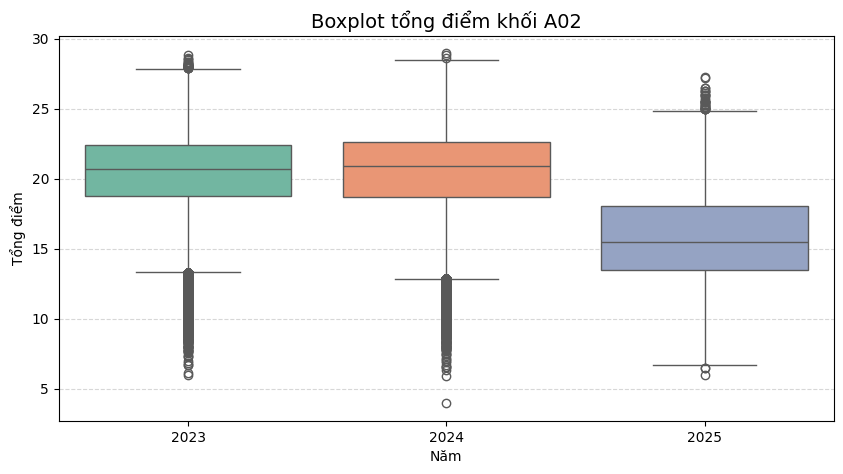


📊 Bảng thống kê mô tả:


,mean,median,std,pct_ge15,pct_ge24
nam_hoc,,,,,
2023,20.426486,20.7,2.725684,96.36,7.72
2024,20.510198,20.9,2.861235,95.70,9.22
2025,15.815566,15.5,3.340573,56.66,1.24


------------------------------------------------------------
================ Hoàn thành EDA khối A02 ================

================ EDA khối C00 ================
📌 [Histogram theo khoảng] Khối: C00


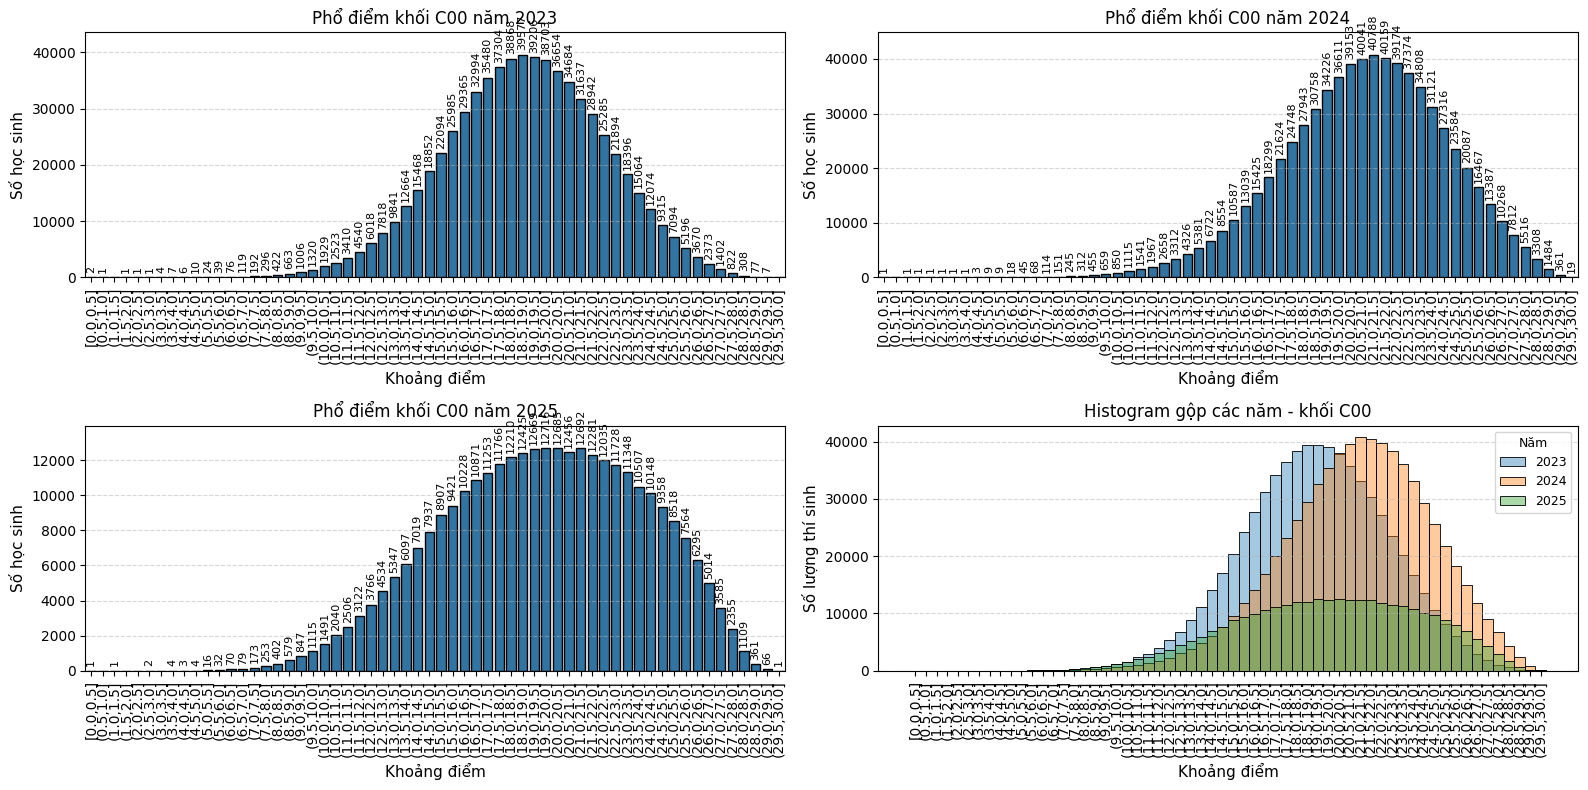

📌 [KDE] Đang xử lý khối: C00


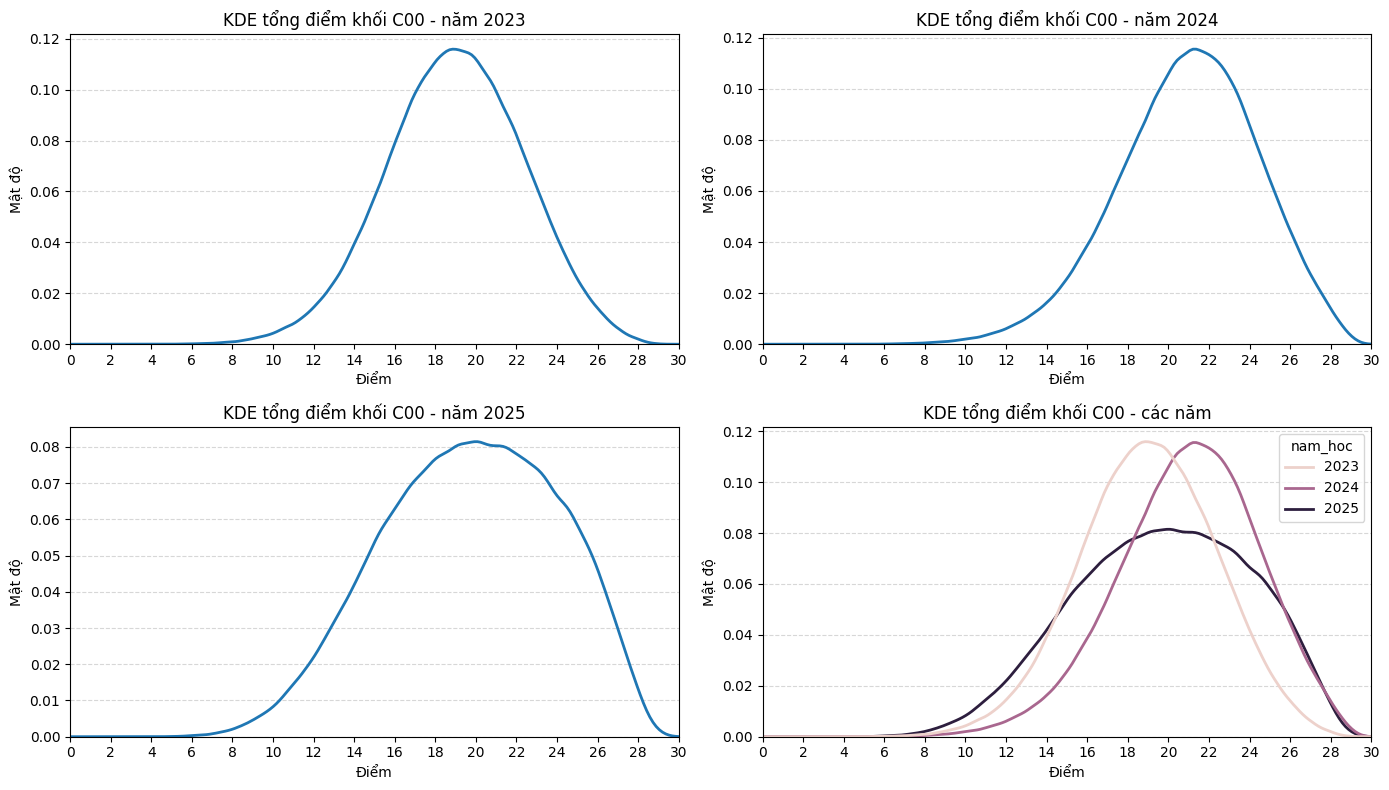

📌 [Boxplot + Stats] Đang xử lý khối: C00


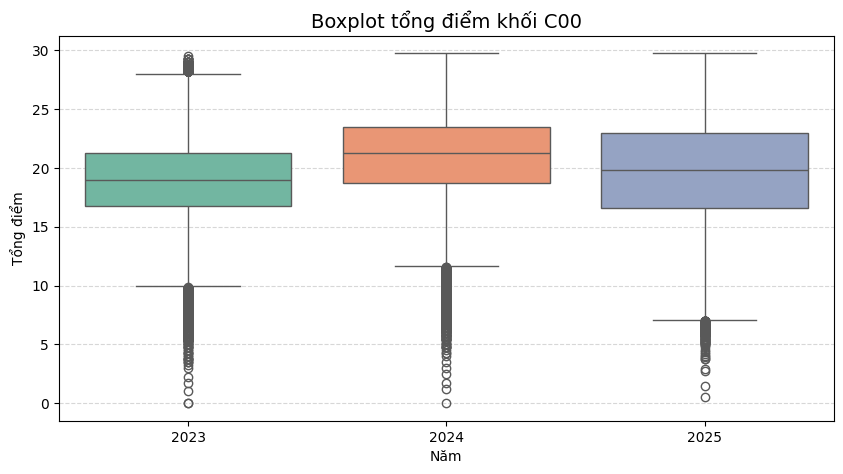


📊 Bảng thống kê mô tả:


,mean,median,std,pct_ge15,pct_ge24
nam_hoc,,,,,
2023,18.974926,19.00,3.378895,88.65,7.25
2024,20.952817,21.25,3.465673,95.17,20.55
2025,19.712084,19.85,4.291575,85.09,18.92


------------------------------------------------------------
================ Hoàn thành EDA khối C00 ================



In [35]:
def visualize_block_eda_all(block_code: str):
    """
    Chạy full EDA cho một khối thi:
    - Histogram theo năm (bin = 0.5)
    - KDE chồng các năm
    - Boxplot so sánh phân phối theo năm + bảng thống kê mean/median/std/%>=15/%>=24.
    """
    print(f"================ EDA khối {block_code} ================")

    # 1. Histogram
    visualize_block_hist(block_code)

    # 2. KDE
    visualize_block_kde(block_code)

    # 3. Boxplot + Stats
    visualize_block_boxplot_and_stats(block_code)

    print(f"================ Hoàn thành EDA khối {block_code} ================\n")
    
# Chạy EDA cho từng khối đã chọn
for blk in blocks_selected:
    visualize_block_eda_all(blk)

******

# Theo Tỉnh thành

In [24]:
import unicodedata
# Map mã tỉnh cũ 
pre_region_map = {
    "Hà Nội": ["01"],
    "Thành phố Hồ Chí Minh": ["02"],
    "Hải Phòng": ["03"],
    "Đà Nẵng" : ["04"],
    "Hà Giang": ["05"],
    "Cao Bằng": ["06"],
    "Lai Châu": ["07"],
    "Lào Cai": ["08"],
    "Tuyên Quang": ["09"],
    "Lạng Sơn": ["10"],
    "Bắc Kạn": ["11"],
    "Thái Nguyên": ["12"],
    "Yên Bái": ["13"],
    "Sơn La": ["14"],
    "Phú Thọ": ["15"],
    "Vĩnh Phúc": ["16"],
    "Quảng Ninh": ["17"],
    "Bắc Giang": ["18"],
    "Bắc Ninh": ["19"],
    "Hải Dương": ["21"],
    "Hưng Yên": ["22"],
    "Hoà Bình": ["23"],
    "Hà Nam": ["24"],
    "Nam Định": ["25"],
    "Thái Bình": ["26"],
    "Ninh Bình": ["27"],
    "Thanh Hoá": ["28"],
    "Nghệ An": ["29"],
    "Hà Tĩnh": ["30"],
    "Quảng Bình": ["31"],
    "Quảng Trị": ["32"],
    "Huế": ["33"],
    "Quảng Nam": ["34"],
    "Quảng Ngãi": ["35"],
    "Kon Tum": ["36"],
    "Bình Định": ["37"],
    "Gia Lai": ["38"],
    "Phú Yên": ["39"],
    "Đắk Lắk": ["40"],
    "Khánh Hoà": ["41"],
    "Lâm Đồng": ["42"],
    "Bình Phước": ["43"],
    "Bình Dương": ["44"],
    "Ninh Thuận": ["45"],
    "Tây Ninh": ["46"],
    "Bình Thuận": ["47"],
    "Đồng Nai": ["48"],
    "Long An": ["49"],
    "Đồng Tháp": ["50"],
    "An Giang": ["51"],
    "Vũng Tàu": ["52"],
    "Tiền Giang": ["53"],
    "Kiên Giang": ["54"],
    "Cần Thơ": ["55"],
    "Bến Tre": ["56"],
    "Vĩnh Long": ["57"],
    "Trà Vinh": ["58"],
    "Sóc Trăng": ["59"],
    "Bạc Liêu": ["60"],
    "Cà Mau": ["61"],
    "Điện Biên": ["62"],
    "Đăk Nông": ["63"],
    "Hậu Giang": ["64"]
}

# Hàm chuẩn hoá tên tỉnh giống logic Export._normalize_name
def normalize_name(name: str) -> str:
    """
    Bỏ dấu, bỏ ký tự lạ, bỏ khoảng trắng.
    Ví dụ: 'Thành phố Hồ Chí Minh' -> 'ThanhPhoHoChiMinh'
    """
    normalized = unicodedata.normalize("NFD", name)
    without_accents = "".join(
        ch for ch in normalized if unicodedata.category(ch) != "Mn"
    )
    cleaned = "".join(
        ch for ch in without_accents if ch.isalnum() or ch == "_"
    )
    return cleaned  # nếu Sheri thích IN HOA thì thêm .upper() ở đây


# --- Tạo menu chọn nhiều tỉnh ---

# Map số thứ tự 1..64 -> tên tỉnh (sắp theo mã 01..64)
province_options = {}
for prov_name, codes in pre_region_map.items():
    for code in codes:
        idx = int(code)        # "01" -> 1
        province_options[idx] = prov_name

print("=== Danh sách tỉnh/thành (theo mã cũ 01–64) ===")
for idx in sorted(province_options.keys()):
    print(f"{idx:2d}: {province_options[idx]}")

raw = input("\nNhập các số tỉnh bạn muốn chọn (vd: 1,3,5 hoặc 1 3 5): ")

# Tách theo dấu phẩy hoặc khoảng trắng
tokens = [t for part in raw.replace(',', ' ').split() for t in [part] if t]

selected_provinces = []      # tên tỉnh gốc (có dấu)
selected_province_keys = []  # tên chuẩn hoá dùng cho folder/file nếu cần

for tok in tokens:
    if not tok.isdigit():
        print(f"⚠ Bỏ qua giá trị không hợp lệ: {tok}")
        continue

    choice = int(tok)

    if choice in province_options:
        prov_name = province_options[choice]
        if prov_name not in selected_provinces:
            selected_provinces.append(prov_name)
            selected_province_keys.append(normalize_name(prov_name))
    else:
        print(f"⚠ Mã tỉnh không hợp lệ: {choice}")

if not selected_provinces:
    print("❌ Lỗi: Không có tỉnh/thành hợp lệ nào được chọn!")
else:
    print("\nBạn đã chọn các tỉnh:")
    for name, key in zip(selected_provinces, selected_province_keys):
        print(f" - {name}  -> key export: {key}")

# Hai biến này dùng cho phần sau:
provinces_selected = selected_provinces        # dùng để filter DataFrame (cột 'tinh')
province_keys_selected = selected_province_keys  # dùng nếu cần trỏ vào CleanData_<key>


=== Danh sách tỉnh/thành (theo mã cũ 01–64) ===
 1: Hà Nội
 2: Thành phố Hồ Chí Minh
 3: Hải Phòng
 4: Đà Nẵng
 5: Hà Giang
 6: Cao Bằng
 7: Lai Châu
 8: Lào Cai
 9: Tuyên Quang
10: Lạng Sơn
11: Bắc Kạn
12: Thái Nguyên
13: Yên Bái
14: Sơn La
15: Phú Thọ
16: Vĩnh Phúc
17: Quảng Ninh
18: Bắc Giang
19: Bắc Ninh
21: Hải Dương
22: Hưng Yên
23: Hoà Bình
24: Hà Nam
25: Nam Định
26: Thái Bình
27: Ninh Bình
28: Thanh Hoá
29: Nghệ An
30: Hà Tĩnh
31: Quảng Bình
32: Quảng Trị
33: Huế
34: Quảng Nam
35: Quảng Ngãi
36: Kon Tum
37: Bình Định
38: Gia Lai
39: Phú Yên
40: Đắk Lắk
41: Khánh Hoà
42: Lâm Đồng
43: Bình Phước
44: Bình Dương
45: Ninh Thuận
46: Tây Ninh
47: Bình Thuận
48: Đồng Nai
49: Long An
50: Đồng Tháp
51: An Giang
52: Vũng Tàu
53: Tiền Giang
54: Kiên Giang
55: Cần Thơ
56: Bến Tre
57: Vĩnh Long
58: Trà Vinh
59: Sóc Trăng
60: Bạc Liêu
61: Cà Mau
62: Điện Biên
63: Đăk Nông
64: Hậu Giang

Bạn đã chọn các tỉnh:
 - Hà Nội  -> key export: HaNoi
 - Hải Phòng  -> key export: HaiPhong
 - Hà Giang  -

## Tải dữ liệu theo tỉnh được chọn

In [25]:
# Kiểm tra đã chọn được ít nhất 1 tỉnh/thành
if not provinces_selected:
    raise ValueError("Không có tỉnh/thành hợp lệ nào được chọn.")

province_dist_dict = {}
province_analysis_dict = {}

# duyệt song song:
for prov_name, prov_key in zip(provinces_selected, province_keys_selected):
    # Lấy dữ liệu phân phối điểm của từng tỉnh (từ Clean_Data / Export)
    df_dist = clean_data.get_province_data(province=prov_key, kind="distribution")
    df_anal = clean_data.get_province_data(province=prov_key, kind="analysis")

    # Đảm bảo có cột 'tinh' mang tên tỉnh gốc (có dấu) để dùng cho EDA
    df_dist = df_dist.copy()
    if "tinh" not in df_dist.columns:
        df_dist["tinh"] = prov_name
    province_dist_dict[prov_name] = df_dist

    df_anal = df_anal.copy()
    if "tinh" not in df_anal.columns:
        df_anal["tinh"] = prov_name
    province_analysis_dict[prov_name] = df_anal

# ---- Gộp distribution của các tỉnh thành 1 DataFrame ----
dist_list = [df for _, df in province_dist_dict.items()]
ChoiceProvince_df = pd.concat(dist_list, ignore_index=True)

# ---- Gộp analysis của các tỉnh thành 1 DataFrame ----
anal_list = [df for _, df in province_analysis_dict.items()]
ChoiceProvince_analyst = pd.concat(anal_list, ignore_index=True)


## Xây dựng hàm trực quan hóa theo Tỉnh

### 🔹Hàm vẽ heatmap phân phối tổng điểm theo năm cho tỉnh đã chọn

In [26]:
def visualize_province_eda(
    province_keys_selected: str,
    bin_width: float = 1.0,
    ax=None,
):
    """
    Vẽ heatmap phân phối tổng điểm theo năm cho 1 tỉnh.

    - Nếu ax=None -> tạo figure riêng.
    - Nếu ax là một subplot -> vẽ vào subplot đó (dùng cho grid nhiều tỉnh).
    """

    # Lấy distribution theo tỉnh (tên tỉnh dùng key gốc, bên trong đã normalize)
    df_dist = clean_data.get_province_data(
        province=normalize_name(province_keys_selected),
        kind="distribution"
    )

    if df_dist.empty:
        print(f"⚠ Không có dữ liệu cho tỉnh/thành {province_keys_selected}")
        return

    # Chuẩn hóa và bin tổng điểm
    df_plot = df_dist.copy()
    df_plot["tong_diem"] = df_plot["tong_diem"].astype(float)
    df_plot["diem_bin"] = (df_plot["tong_diem"] / bin_width).round(0) * bin_width

    # index = năm, columns = bin điểm (tăng dần)
    pivot_table = df_plot.pivot_table(
        index="nam_hoc",
        columns="diem_bin",
        values="so_hoc_sinh",
        aggfunc="sum",
        fill_value=0
    ).sort_index(axis=0).sort_index(axis=1)

    if pivot_table.empty:
        print(f"⚠ Không có dữ liệu phân phối hợp lệ cho tỉnh/thành {province_keys_selected}")
        return

    # Nếu không truyền ax → tạo figure riêng
    created_fig = False
    if ax is None:
        created_fig = True
        fig, ax = plt.subplots(figsize=(12, 5))

    sns.heatmap(
        pivot_table,
        cmap="YlGnBu",
        cbar_kws={"label": "Số học sinh"},
        linewidths=0.3,
        linecolor="white",
        annot=False,
        ax=ax
    )

    ax.set_title(
        f"Heat Map theo năm - {province_keys_selected}",
        fontsize=14
    )
    ax.set_xlabel("Tổng điểm (bin)", fontsize=12)
    ax.set_ylabel("Năm học", fontsize=12)

    # Format nhãn trục X (điểm) cho gọn
    new_xlabels = []
    for lab in ax.get_xticklabels():
        txt = lab.get_text()
        try:
            v = float(txt)
            new_xlabels.append(f"{v:g}")
        except ValueError:
            new_xlabels.append(txt)

    ax.set_xticklabels(new_xlabels, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if created_fig:
        plt.tight_layout()
        plt.show()


### Hàm trực quan hóa với số lượng tỉnh nhiều:

In [27]:
def visualize_province_eda_grid(
    provinces_selected,
    bin_width: float = 1.0,
    max_cols: int = 3
):
    """
    Vẽ heatmap cho nhiều tỉnh trên cùng 1 figure.
    - Số subplot = số tỉnh.
    - max_cols: tối đa bao nhiêu cột trong grid (mặc định 3).
    """
    if not provinces_selected:
        print("⚠ Danh sách tỉnh rỗng.")
        return

    n_prov = len(provinces_selected)
    n_cols = min(n_prov, max_cols)
    n_rows = math.ceil(n_prov / n_cols)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(5 * n_cols, 4 * n_rows),
        squeeze=False
    )

    for i, prov in enumerate(provinces_selected):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        visualize_province_eda(prov, bin_width=bin_width, ax=ax)

    # Ẩn các ô thừa nếu số tỉnh không lấp đầy grid
    for j in range(n_prov, n_rows * n_cols):
        r = j // n_cols
        c = j % n_cols
        axes[r][c].set_visible(False)

    plt.tight_layout()
    plt.show()


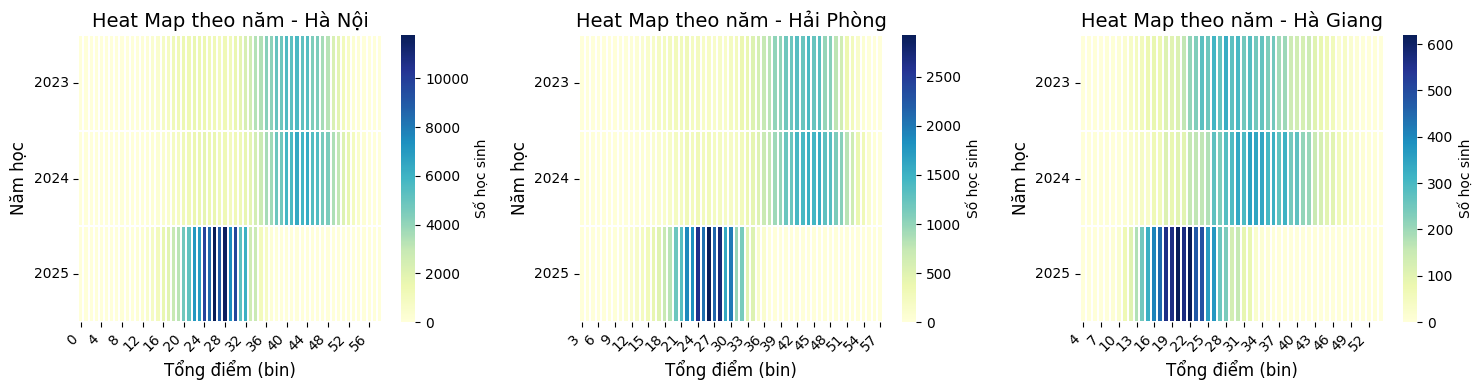

In [28]:
visualize_province_eda_grid(
    provinces_selected=provinces_selected,
    bin_width=1.0,
    max_cols=3
)

### 🔹Hàm vẽ box plot phân phối tổng điểm theo năm cho tỉnh đã chọn

In [29]:
def visualize_province_boxplot(
    province_keys_selected: str,
    ax=None,
):
    """
    Vẽ boxplot tổng điểm theo năm cho 1 tỉnh/thành.

    Parameters
    ----------
    province_keys_selected : str
        Tên tỉnh gốc (có dấu) dùng để hiển thị.
    ax : matplotlib.axes.Axes, optional
        Nếu truyền ax -> vẽ vào subplot đó (dùng cho grid).
        Nếu None -> tự tạo figure riêng.
    """
    # Lấy distribution theo tỉnh (tên truyền vào get_province_data là tên đã normalize)
    df_dist = clean_data.get_province_data(
        province=normalize_name(province_keys_selected),
        kind="distribution"
    )

    # Kiểm tra dữ liệu có rỗng không
    if df_dist.empty:
        print(f"⚠ Không có dữ liệu cho tỉnh/thành {province_keys_selected}")
        return

    # Tái tạo dữ liệu thô từ tần suất
    raw = []
    for year in sorted(df_dist["nam_hoc"].unique()):
        df_y = df_dist[df_dist["nam_hoc"] == year]
        scores = np.repeat(
            df_y["tong_diem"].values,
            df_y["so_hoc_sinh"].values.astype(int)
        )
        raw.append(pd.DataFrame({"nam_hoc": year, "tong_diem": scores}))

    # Tạo dataframe đầy đủ từ dữ liệu thô
    full_df = pd.concat(raw, ignore_index=True)

    # Nếu không truyền ax thì tự tạo figure riêng
    created_fig = False
    if ax is None:
        created_fig = True
        fig, ax = plt.subplots(figsize=(10, 5))

    # Vẽ boxplot
    sns.boxplot(
        data=full_df,
        x="nam_hoc",
        y="tong_diem",
        hue="nam_hoc",   # thêm hue để tránh warning version mới của seaborn
        dodge=False,
        palette="Set3",
        ax=ax,
    )

    ax.set_title(f"Boxplot tổng điểm - {province_keys_selected}", fontsize=14)
    ax.set_xlabel("Năm")
    ax.set_ylabel("Tổng điểm")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Bỏ legend trùng lặp
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

    if created_fig:
        plt.tight_layout()
        plt.show()


In [30]:
def visualize_province_boxplot_grid(
    provinces_selected,
    max_cols: int = 3,
):
    """
    Vẽ boxplot tổng điểm theo năm cho N tỉnh trên cùng 1 figure dạng grid.

    Parameters
    ----------
    provinces_selected : list[str]
        Danh sách tên tỉnh (có dấu) để vẽ.
    max_cols : int, default 3
        Số cột tối đa trong grid subplot.
    """
    if not provinces_selected:
        print("⚠ Danh sách tỉnh rỗng.")
        return

    # Tính số hàng/cột cho grid
    n_prov = len(provinces_selected)
    n_cols = min(n_prov, max_cols)
    n_rows = math.ceil(n_prov / n_cols)

    # Tạo figure và axes dạng grid
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(5 * n_cols, 4 * n_rows),
        squeeze=False
    )

    for i, prov in enumerate(provinces_selected):
        r = i // n_cols
        c = i % n_cols
        ax = axes[r][c]
        visualize_province_boxplot(prov, ax=ax)

    # Ẩn các ô thừa nếu số tỉnh không lấp đầy grid
    for j in range(n_prov, n_rows * n_cols):
        r = j // n_cols
        c = j % n_cols
        axes[r][c].set_visible(False)

    plt.tight_layout()
    plt.show()

In [31]:
print(ChoiceProvince_df.head())
print(ChoiceProvince_analyst.head())

   nam_hoc    tinh  tong_diem  so_hoc_sinh
0     2023  Hà Nội       0.00            1
1     2023  Hà Nội       0.75            1
2     2023  Hà Nội       1.40            1
3     2023  Hà Nội       1.80            1
4     2023  Hà Nội       2.20            1
   nam_hoc       mean  median   mode       std   min    max       tinh
0     2023  37.324483   39.20  41.00  9.029400  0.00  56.30     Hà Nội
1     2024  39.081294   40.95  43.20  8.888627  1.75  57.85     Hà Nội
2     2025  25.724696   26.10  28.75  4.820202  1.70  52.00     Hà Nội
3     2023  39.020116   41.10  40.55  9.105149  4.50  56.05  Hải Phòng
4     2024  40.876944   42.75  43.20  8.747743  4.00  56.80  Hải Phòng


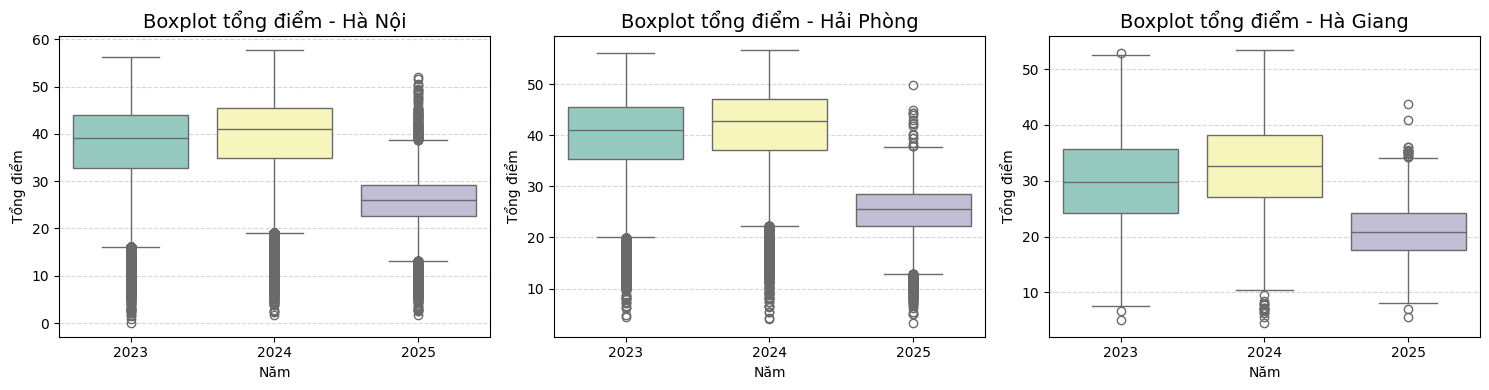

In [32]:
visualize_province_boxplot_grid(provinces_selected, max_cols=3)

## Kiểm định ANOVA vs t-test